In [1]:
import pyipn
from pyipn.io import import_lc
from pyipn import copy_template, Universe

import h5py
from astropy.time import Time, TimeDelta
import datetime as dt
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
#find all gbm and acs lightcurves with time difference less than delta_t

delta_t = 20.
data_dir = "/home/msinghart/data/"
close = import_lc.close_triggers_int_gbm(delta_t, data_dir=data_dir)
print(len(close))

127


<IPython.core.display.Javascript object>


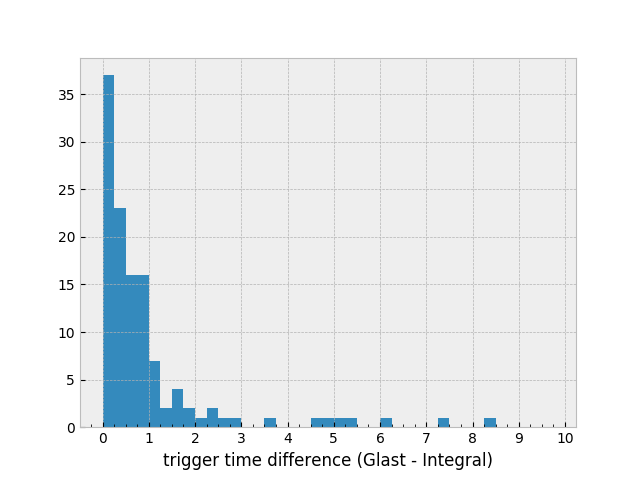

In [3]:
#analyze and plot time difference between triggers
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

timediff = []
for key, elem in close.items():
    timediff.append(elem[0].total_seconds())

timediff = np.array(timediff)
timediff_abs = np.absolute(timediff)
#hist, bins = np.histogram(timediff)

plt.style.use('bmh')
%matplotlib notebook
bins = np.arange(0., 10, 0.25)
fig, axs = plt.subplots()
axs.hist(timediff_abs, bins=bins)
axs.set_xlabel('trigger time difference (Glast - Integral)')
axs.xaxis.set_major_locator(MultipleLocator(1))
axs.xaxis.set_minor_locator(AutoMinorLocator(4))
fig.savefig('N_triggertimediff_abs.pdf')

<IPython.core.display.Javascript object>


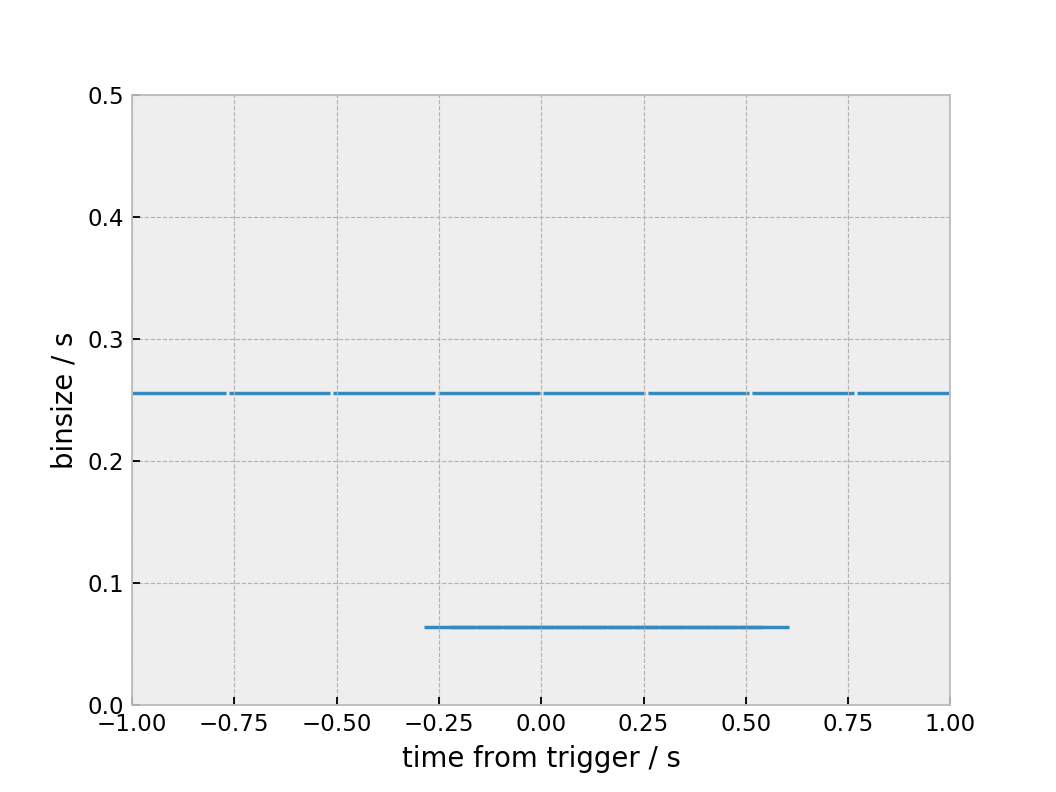

In [65]:
#analyze and plot bin sizes of GBM trigdat file
binsize_gbm = list(close.items())[0][1]['binsize']
time_gbm = list(close.items())[0][1]['time']
time_gbm = time_gbm + 0.5*binsize_gbm
trigtime_gbm = list(close.items())[0][1]['trigtime'].unix
time_from_trigger = time_gbm-trigtime_gbm

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib as mpl
plt.style.use('bmh')
mpl.rc('lines', linewidth=1.5)
%matplotlib notebook

fig, axs = plt.subplots()
axs.scatter(time_from_trigger, binsize_gbm, s=binsize_gbm*7700, marker='_')
#axs.axvline(x=0., color='red')
axs.set_xlabel('time from trigger / s')
axs.set_ylabel('binsize / s')
axs.set_xlim(-1.,1.)
axs.set_ylim(0.,.5)
#axs.xaxis.set_major_locator(MultipleLocator(10))
#axs.xaxis.set_minor_locator(AutoMinorLocator(2))
fig.savefig('binsize_gbm_zoom_zoom.pdf')

In [18]:
import pyipn.cc
import pdb
#import stan_utility
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.style.use('bmh')
mpl.rc('lines', linewidth=1)
mpl.rcParams['figure.figsize'] = [9, 20]

#model = stan_utility.compile_model('/home/msinghart/pyipn/prototype/rff.stan', model_name='rff')

np.set_printoptions(threshold=np.inf, precision=16)
j = 0
maxims = []
maxims_i_lin = []
maxims_i_spl = []

relevant_width = 40.
stepsize = 0.1

for key, elem in close.items():
    j += 1
    gbm = elem[1]
    integral = elem[2]
    trigtime_gbm = gbm['trigtime']
    trigtime_int = integral['trigtime']
    time_gbm = gbm['time']
    time_int = integral['time']
    #only consider channels 5 to 8 for NaI detectors and all for BGO detectors
    #rate_gbm = np.sum(gbm['rate'][:][4:8][0:12], axis=(2,1)) + np.sum(gbm['rate'][:][:][12:14], axis=(2,1))
    rate_gbm = np.sum(gbm['combinedchannels'], axis=0)
    count_int = integral['count']
    binsize_gbm = gbm['binsize']
    binsize_int = np.zeros(time_int.size)+0.05
    
    relevant_gbm = np.where(abs(time_gbm - trigtime_gbm.unix) <= relevant_width)
    re_binsize_gbm = binsize_gbm[relevant_gbm]
    re_time_gbm = time_gbm[relevant_gbm]+0.5*re_binsize_gbm    
    re_rate_gbm = rate_gbm[relevant_gbm]
    
    re_time_gbm_sort = np.argsort(re_time_gbm)
    re_binsize_gbm = re_binsize_gbm[re_time_gbm_sort]
    re_time_gbm = re_time_gbm[re_time_gbm_sort]
    re_rate_gbm = re_rate_gbm[re_time_gbm_sort]
    
    relevant_int = np.where(abs(time_int - trigtime_gbm.unix) <= relevant_width)
    re_binsize_int = binsize_int[relevant_int]
    re_time_int = time_int[relevant_int]+0.5*re_binsize_int
    re_count_int = count_int[relevant_int]
    
    #print(trigtime_gbm)
    #print(time_gbm)
    #print(binsize_gbm)
    #print(rate_gbm)
    
#     fig, axs = plt.subplots(5)
#     fig.subplots_adjust(hspace=0.35)
#     axs[0].plot(re_time_gbm, re_rate_gbm)
#     axs[0].axvline(x=trigtime_gbm.unix, color='red')
#     axs[0].set_title('GBM')
#     axs[0].set_xlabel('time')
#     axs[0].set_ylabel('combined rate')
    
#     axs[1].plot(re_time_int, re_count_int)
#     axs[1].axvline(x=trigtime_int.unix, color='red')
#     axs[1].set_title('INTEGRAL')
#     axs[1].set_xlabel('time')
#     axs[1].set_ylabel('count')
    
    uccf, lags = pyipn.cc.uccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int)
    
#     axs[1, 0].scatter(lags, uccf, marker=',', s=1)
#     axs[1, 0].set_title('UCCF')
#     axs[1, 0].set_xlabel('time')
#     axs[1, 0].set_ylabel('uccf')

    minimum = -3.
    maximum = 3.
    timediff = stepsize

    bins, dcf, sigma_dcf = pyipn.cc.dcf(uccf, lags, start=minimum, stop=maximum, step=timediff)
    smax_d = bins[np.argmax(dcf)]

    size=0.5
    add = 0
    #gaussian fit
#     try:
#         gaus, popt, argmax =  pyipn.cc.gaussian_fit(bins, dcf, 1.5, size, add)
#     except RuntimeError:
#         continue
#     maxim = popt[1]
#     maxims.append({"trigtime": trigtime_gbm, "dt": maxim})
    
    #parabolic fit
    parab, maxim, argmax = pyipn.cc.parabolic_fit(bins, dcf, 1.5, size)    
    if parab[0] < 0.:
        maxims.append({"trigtime": trigtime_gbm, "dt": maxim, "dtmax": smax_d})
    
    trange = np.arange(argmax-size, argmax+size, 0.01)
    parab_t = np.poly1d(parab)(trange)
#     gaussian = gaus(trange, popt[0], popt[1], popt[2], popt[3])
    
    #plot dcf and parabolic fit 
#     fig1, axs1 = plt.subplots()
#     #axs1.errorbar(bins, dcf, yerr=sigma_dcf)

#     axs[2].plot(bins, dcf)
#     axs[2].plot(trange, parab_t, color='red')
#     axs[2].axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
#     axs[2].set_title('DCF')
#     axs[2].set_xlabel('lag')
#     axs[2].set_ylabel('dcf')
#     axs[2].xaxis.set_major_locator(MultipleLocator(1.))
#     axs[2].xaxis.set_minor_locator(AutoMinorLocator(10))
#     axs[2].grid(which='major', color='#CCCCCC', linestyle='--')
#     axs[2].grid(which='minor', color='#CCCCCC', linestyle=':')
    
#     print(str(j)+'/'+str(len(close)))
#     print(bins[np.argmax(dcf)])
    print(key)
#     print("dcf max: " + str(maxim))
    
    #locally normalized discrete correlation function

#     lnbins, lndcf, sigma_lndcf = pyipn.cc.lndcf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, lags, start=minimum, stop=maximum, step=timediff)

#     axs1.plot(lnbins, lndcf)
#     axs1.axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
#     axs1.set_title('LNDCF')
#     axs1.set_xlabel('lag')
#     axs1.set_ylabel('lndcf')
#     axs1.xaxis.set_major_locator(MultipleLocator(1.))
#     axs1.xaxis.set_minor_locator(AutoMinorLocator(10))
#     axs1.grid(which='major', color='#CCCCCC', linestyle='--')
#     axs1.grid(which='minor', color='#CCCCCC', linestyle=':')
    
#     print(str(j)+'/'+str(len(close)))
#     print(lnbins[np.argmax(lndcf)])
    
    #create spl interpolated correlation function
    tau = np.arange(-3., 3., stepsize)
    evaltimes, iccf = pyipn.cc.iccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, tau, method='spline')
    smax = evaltimes[np.argmax(iccf)]
    
    #gaussian fit
#     try:
#         gaus, popt_i, argmax_i =  pyipn.cc.gaussian_fit(evaltimes, iccf, 1.5, size, add)
#     except RuntimeError:
#         continue
#     maxim_i = popt_i[1]
#     maxims_i.append({"trigtime": trigtime_gbm, "dt": maxim_i})
    
    #parabolic fit
    parab_i, maxim_i_spl, argmax_i = pyipn.cc.parabolic_fit(evaltimes, iccf, 1.5, size)   
    if parab_i[0] < 0.:
        maxims_i_spl.append({"trigtime": trigtime_gbm, "dt": maxim_i_spl, "dtmax": smax})
    
    trange_i = np.arange(argmax_i-size, argmax_i+size, 0.01)
    parab_t_i = np.poly1d(parab_i)(trange_i)    
#     gaussian_i = gaus(trange_i, popt_i[0], popt_i[1], popt_i[2], popt_i[3])

    
    #plot dcf and parabolic fit 

#     axs[3].plot(evaltimes, iccf)
#     axs[3].axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
#     axs[3].plot(trange_i, parab_t_i, color='red')
#     axs[3].set_title('ICCF')
#     axs[3].set_xlabel('lag')
#     axs[3].set_ylabel('iccf')
#     axs[3].xaxis.set_major_locator(MultipleLocator(1.))
#     axs[3].xaxis.set_minor_locator(AutoMinorLocator(10))
#     axs[3].grid(which='major', color='#CCCCCC', linestyle='--')
#     axs[3].grid(which='minor', color='#CCCCCC', linestyle=':')
    
    #create lin interpolated correlation function
    tau = np.arange(-3., 3., stepsize)
    evaltimes, iccf = pyipn.cc.iccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, tau, method='linear')
    smax = evaltimes[np.argmax(iccf)]
    
    #gaussian fit
#     try:
#         gaus, popt_i, argmax_i =  pyipn.cc.gaussian_fit(evaltimes, iccf, 1.5, size, add)
#     except RuntimeError:
#         continue
#     maxim_i = popt_i[1]
#     maxims_i.append({"trigtime": trigtime_gbm, "dt": maxim_i})
    
    #parabolic fit
    parab_i, maxim_i_lin, argmax_i = pyipn.cc.parabolic_fit(evaltimes, iccf, 1.5, size)   
    if parab_i[0] < 0.:
        maxims_i_lin.append({"trigtime": trigtime_gbm, "dt": maxim_i_lin, "dtmax": smax})
    
    trange_i = np.arange(argmax_i-size, argmax_i+size, 0.01)
    parab_t_i = np.poly1d(parab_i)(trange_i)    
#     gaussian_i = gaus(trange_i, popt_i[0], popt_i[1], popt_i[2], popt_i[3])

    
    #plot dcf and parabolic fit 

#     axs[4].plot(evaltimes, iccf)
#     axs[4].axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
#     axs[4].plot(trange_i, parab_t_i, color='red')
#     axs[4].set_title('ICCF')
#     axs[4].set_xlabel('lag')
#     axs[4].set_ylabel('iccf')
#     axs[4].xaxis.set_major_locator(MultipleLocator(1.))
#     axs[4].xaxis.set_minor_locator(AutoMinorLocator(10))
#     axs[4].grid(which='major', color='#CCCCCC', linestyle='--')
#     axs[4].grid(which='minor', color='#CCCCCC', linestyle=':')
    
#     print("iccf max: " + str(maxim_i))
    
    
#     k=50
#     N_model = 300
#     omega=np.random.randn(k)
#     predict_time = np.linspace((trigtime_gbm.unix-30.) ,(trigtime_gbm.unix+30.) ,N_model)
    
#     data = dict(N1=len(re_rate_gbm),
#             time1=re_time_gbm,
#             counts1=re_rate_gbm.astype(int),
#             exposure1=re_binsize_gbm,
#             exposure2=re_binsize_int,
#             N2=len(re_count_int),
#             time2=re_time_int,
#             counts2=re_count_int.astype(int),
#             k=k,
#             bw=.7,
#             omega=omega,
#             N_model=N_model,
#             predict_time=predict_time
           
           
           
#            )
    
#     fit = model.sampling(warmup=200,iter=400,data=data, chains=4, seed=1234,
#                      control = dict(max_treedepth=15, adapt_delta=.9)
                    

#                     )
        
#     fits.append(fit)

2018-01-10_14:35:59
2018-01-12_20:12:28
2018-01-13_00:16:00
2018-01-13_02:47:06
2018-01-13_10:02:05
2018-01-26_02:16:31
2018-02-10_12:24:38
2018-02-18_15:14:05
2018-02-27_05:04:16
2018-03-30_21:23:15
2018-04-01_20:17:36
2018-04-02_09:44:59
2018-04-02_11:32:11
2018-04-05_04:02:53
2018-04-09_08:18:18
2018-04-12_10:12:06
2018-04-13_02:49:43
2018-04-16_08:09:26
2018-04-17_16:32:45
2018-04-18_06:44:06
2018-04-23_00:47:03
2018-04-26_00:06:42
2018-04-27_10:37:03
2018-04-28_02:27:15
2018-05-04_03:15:53
2018-05-11_08:43:35
2018-05-15_19:32:24
2018-05-23_18:46:28
2018-05-25_03:37:59
2018-06-05_10:59:25
2018-06-11_03:29:01
2018-06-15_11:05:56
2018-06-18_00:43:13
2018-06-23_20:22:30
2018-06-25_22:34:41
2018-06-26_09:23:50
2018-07-01_11:15:04
2018-07-03_21:01:40
2018-07-03_22:46:51
2018-07-09_02:22:03
2018-07-15_17:47:19
2018-07-15_18:07:05
2018-07-18_01:57:44
2018-07-18_04:49:00
2018-07-18_18:18:24
2018-07-20_05:06:02
2018-07-20_14:21:39
2018-07-23_18:09:48
2018-07-28_17:29:02
2018-07-28_21:09:58


2018-10-26_12:57:00
Using cached StanModel


Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self

KeyboardInterrupt: 

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in 

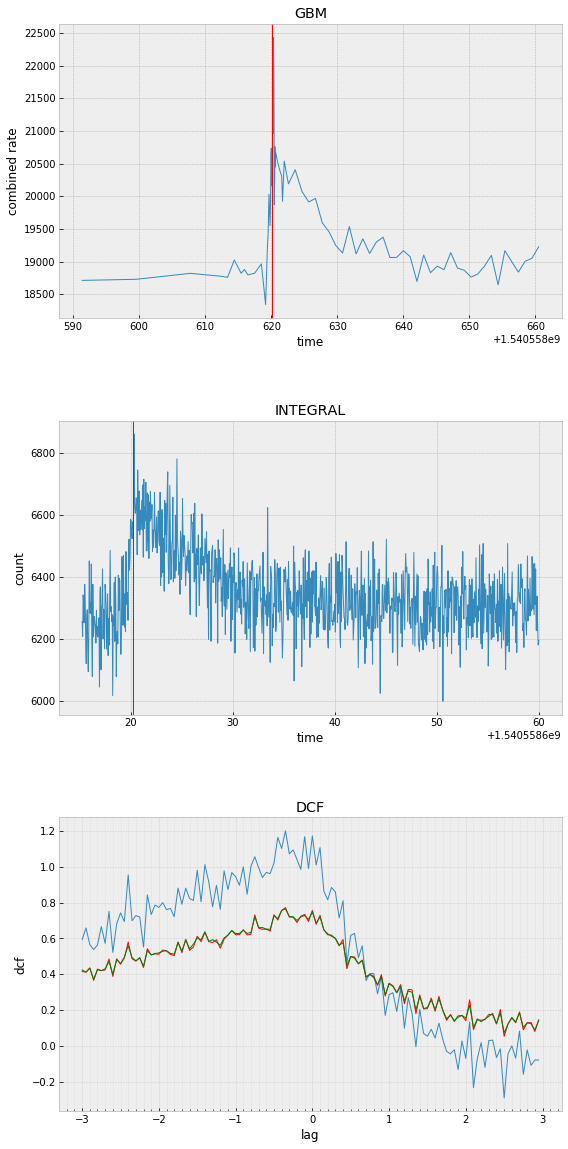

In [6]:
#same as above but withou for loop
import pyipn.cc
import pdb
import stan_utility
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.style.use('bmh')
mpl.rc('lines', linewidth=1)
mpl.rcParams['figure.figsize'] = [9, 20]

np.set_printoptions(threshold=np.inf, precision=16)


relevant_width = 40.
key = '2018-10-26_12:57:00'

elem = close[key]
gbm = elem[1]
integral = elem[2]
trigtime_gbm = gbm['trigtime']
trigtime_int = integral['trigtime']
time_gbm = gbm['time']
time_int = integral['time']
#only consider channels 5 to 8 for NaI detectors and all for BGO detectors
#rate_gbm = np.sum(gbm['rate'][:][4:8][0:12], axis=(2,1)) + np.sum(gbm['rate'][:][:][12:14], axis=(2,1))
rate_gbm = np.sum(gbm['combinedchannels'], axis=0)
count_int = integral['count']
binsize_gbm = gbm['binsize']
binsize_int = np.zeros(time_int.size)+0.05

relevant_gbm = np.where(abs(time_gbm - trigtime_gbm.unix) <= relevant_width)
re_binsize_gbm = binsize_gbm[relevant_gbm]
re_time_gbm = time_gbm[relevant_gbm]+0.5*re_binsize_gbm    
re_rate_gbm = rate_gbm[relevant_gbm]

re_time_gbm_sort = np.argsort(re_time_gbm)
re_binsize_gbm = re_binsize_gbm[re_time_gbm_sort]
re_time_gbm = re_time_gbm[re_time_gbm_sort]
re_rate_gbm = re_rate_gbm[re_time_gbm_sort]

relevant_int = np.where(abs(time_int - trigtime_gbm.unix) <= relevant_width)
re_binsize_int = binsize_int[relevant_int]
re_time_int = time_int[relevant_int]+0.5*re_binsize_int
re_count_int = count_int[relevant_int]

#print(trigtime_gbm)
#print(time_gbm)
#print(binsize_gbm)
#print(rate_gbm)

fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.35)
axs[0].plot(re_time_gbm, re_rate_gbm)
axs[0].axvline(x=trigtime_gbm.unix, color='red')
axs[0].set_title('GBM')
axs[0].set_xlabel('time')
axs[0].set_ylabel('combined rate')

axs[1].plot(re_time_int, re_count_int)
axs[1].axvline(x=trigtime_int.unix, color='red')
axs[1].set_title('INTEGRAL')
axs[1].set_xlabel('time')
axs[1].set_ylabel('count')

uccf, lags = pyipn.cc.uccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int)

#     axs[1, 0].scatter(lags, uccf, marker=',', s=1)
#     axs[1, 0].set_title('UCCF')
#     axs[1, 0].set_xlabel('time')
#     axs[1, 0].set_ylabel('uccf')

minimum = -3.
maximum = 3.
timediff = stepsize

bins, dcf, sigma_dcf = pyipn.cc.dcf(uccf, lags, start=minimum, stop=maximum, step=timediff)
smax_d = bins[np.argmax(dcf)]

size=0.5
add = 0
#gaussian fit
#     try:
#         gaus, popt, argmax =  pyipn.cc.gaussian_fit(bins, dcf, 1.5, size, add)
#     except RuntimeError:
#         continue
#     maxim = popt[1]
#     maxims.append({"trigtime": trigtime_gbm, "dt": maxim})

#parabolic fit
parab, maxim, argmax = pyipn.cc.parabolic_fit(bins, dcf, 1.5, size)

trange = np.arange(argmax-size, argmax+size, 0.01)
parab_t = np.poly1d(parab)(trange)
#     gaussian = gaus(trange, popt[0], popt[1], popt[2], popt[3])

#plot dcf and parabolic fit 
#     fig1, axs1 = plt.subplots()
#     #axs1.errorbar(bins, dcf, yerr=sigma_dcf)

axs[2].plot(bins, dcf)
#axs[2].plot(trange, parab_t, color='red')
#axs[2].axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
axs[2].set_title('DCF')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('dcf')
axs[2].xaxis.set_major_locator(MultipleLocator(1.))
axs[2].xaxis.set_minor_locator(AutoMinorLocator(10))
axs[2].grid(which='major', color='#CCCCCC', linestyle='--')
axs[2].grid(which='minor', color='#CCCCCC', linestyle=':')

#     print(str(j)+'/'+str(len(close)))
#     print(bins[np.argmax(dcf)])
print(key)
#     print("dcf max: " + str(maxim))

#locally normalized discrete correlation function

#     lnbins, lndcf, sigma_lndcf = pyipn.cc.lndcf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, lags, start=minimum, stop=maximum, step=timediff)

#     axs1.plot(lnbins, lndcf)
#     axs1.axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
#     axs1.set_title('LNDCF')
#     axs1.set_xlabel('lag')
#     axs1.set_ylabel('lndcf')
#     axs1.xaxis.set_major_locator(MultipleLocator(1.))
#     axs1.xaxis.set_minor_locator(AutoMinorLocator(10))
#     axs1.grid(which='major', color='#CCCCCC', linestyle='--')
#     axs1.grid(which='minor', color='#CCCCCC', linestyle=':')

#     print(str(j)+'/'+str(len(close)))
#     print(lnbins[np.argmax(lndcf)])

#create spl interpolated correlation function
tau = np.arange(-3., 3., stepsize)
evaltimes, iccf = pyipn.cc.iccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, tau, method='spline')
smax = evaltimes[np.argmax(iccf)]

#gaussian fit
#     try:
#         gaus, popt_i, argmax_i =  pyipn.cc.gaussian_fit(evaltimes, iccf, 1.5, size, add)
#     except RuntimeError:
#         continue
#     maxim_i = popt_i[1]
#     maxims_i.append({"trigtime": trigtime_gbm, "dt": maxim_i})

#parabolic fit
parab_i, maxim_i_spl, argmax_i = pyipn.cc.parabolic_fit(evaltimes, iccf, 1.5, size)

trange_i = np.arange(argmax_i-size, argmax_i+size, 0.01)
parab_t_i = np.poly1d(parab_i)(trange_i)    
#     gaussian_i = gaus(trange_i, popt_i[0], popt_i[1], popt_i[2], popt_i[3])


#plot dcf and parabolic fit 

axs[2].plot(evaltimes, iccf, color='red')
# axs[3].axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
# axs[3].plot(trange_i, parab_t_i, color='red')
# axs[3].set_title('Spline ICCF')
# axs[3].set_xlabel('lag')
# axs[3].set_ylabel('iccf')
# axs[3].xaxis.set_major_locator(MultipleLocator(1.))
# axs[3].xaxis.set_minor_locator(AutoMinorLocator(10))
# axs[3].grid(which='major', color='#CCCCCC', linestyle='--')
# axs[3].grid(which='minor', color='#CCCCCC', linestyle=':')

#create lin interpolated correlation function
tau = np.arange(-3., 3., stepsize)
evaltimes, iccf = pyipn.cc.iccf(re_time_gbm, re_rate_gbm, re_time_int, re_count_int, tau, method='linear')
smax = evaltimes[np.argmax(iccf)]

#gaussian fit
#     try:
#         gaus, popt_i, argmax_i =  pyipn.cc.gaussian_fit(evaltimes, iccf, 1.5, size, add)
#     except RuntimeError:
#         continue
#     maxim_i = popt_i[1]
#     maxims_i.append({"trigtime": trigtime_gbm, "dt": maxim_i})

#parabolic fit
parab_i, maxim_i_lin, argmax_i = pyipn.cc.parabolic_fit(evaltimes, iccf, 1.5, size)

trange_i = np.arange(argmax_i-size, argmax_i+size, 0.01)
parab_t_i = np.poly1d(parab_i)(trange_i)    
#     gaussian_i = gaus(trange_i, popt_i[0], popt_i[1], popt_i[2], popt_i[3])


#plot dcf and parabolic fit 

axs[2].plot(evaltimes, iccf, color='green')
# axs[4].axvline(x=(trigtime_gbm.unix-trigtime_int.unix), color='red')
# axs[4].plot(trange_i, parab_t_i, color='red')
# axs[4].set_title('Linear ICCF')
# axs[4].set_xlabel('lag')
# axs[4].set_ylabel('iccf')
# axs[4].xaxis.set_major_locator(MultipleLocator(1.))
# axs[4].xaxis.set_minor_locator(AutoMinorLocator(10))
# axs[4].grid(which='major', color='#CCCCCC', linestyle='--')
# axs[4].grid(which='minor', color='#CCCCCC', linestyle=':')

model = stan_utility.compile_model('/home/msinghart/pyipn/prototype/rff.stan', model_name='rff')

k=50
N_model = 300
omega=np.random.randn(k)
predict_time = np.linspace((trigtime_gbm.unix-30.) ,(trigtime_gbm.unix+30.) ,N_model)

data = dict(N1=len(re_rate_gbm),
        time1=re_time_gbm,
        counts1=re_rate_gbm.astype(int),
        exposure1=re_binsize_gbm,
        exposure2=re_binsize_int,
        N2=len(re_count_int),
        time2=re_time_int,
        counts2=re_count_int.astype(int),
        k=k,
        bw=.7,
        omega=omega,
        N_model=N_model,
        predict_time=predict_time



       )

fit = model.sampling(warmup=1500,iter=2000,data=data, chains=3, seed=1234,
                 control = dict(max_treedepth=15, adapt_delta=.9)


                )

fig.savefig('middle_combined(db_splr_ling).pdf')
# print(maxim_i_spl)
# print(maxim_i_lin)

In [7]:
#plot stan results
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [9, 15]

with plt.style.context('bmh'):
    fit.plot(['beta1','beta2',
          'dt',
          'log_amplitude1',
           'log_amplitude2',
         ]);

NameError: name 'fit' is not defined

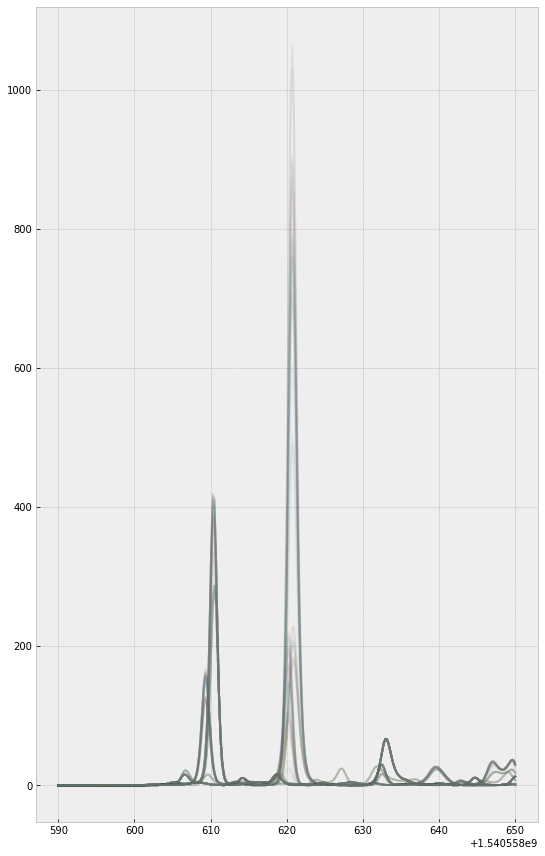

In [32]:
#plot stan results
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [9, 15]

with plt.style.context('bmh'):
    predict = fit.extract('predict')['predict']   
    predict_time = fit.data['predict_time']
    fig, ax = plt.subplots()
    
    for p in predict:

        ax.plot(predict_time, p, alpha=0.03)

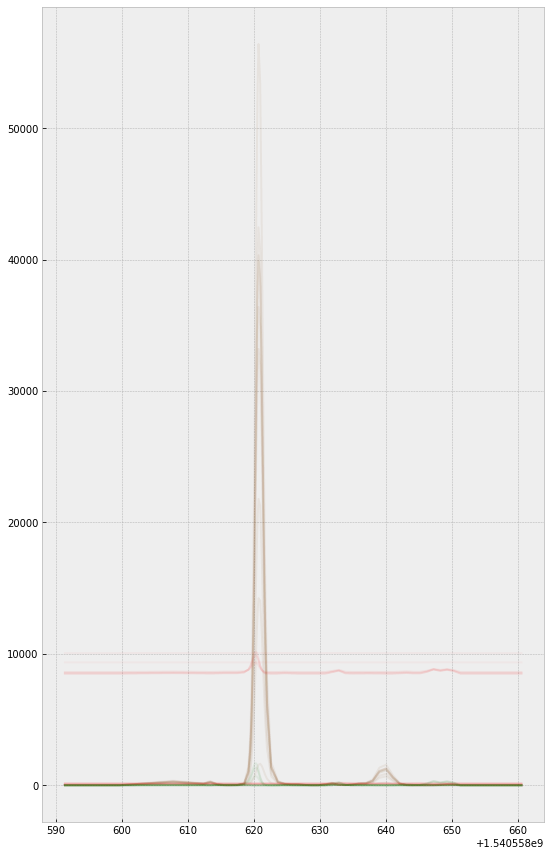

In [33]:
#plot stan results
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [9, 15]

with plt.style.context('bmh'):
    fig, ax = plt.subplots()
    
    bkg = fit.extract("bkg1")["bkg1"]
    fhat = fit.extract("fhat1")["fhat1"]

    for y, b in zip(fhat[::10], bkg[::10]):

        ax.plot(re_time_gbm, y, alpha=0.03, color='green')
        ax.plot(re_time_gbm, (y + b), alpha=0.03, color='red')

<IPython.core.display.Javascript object>


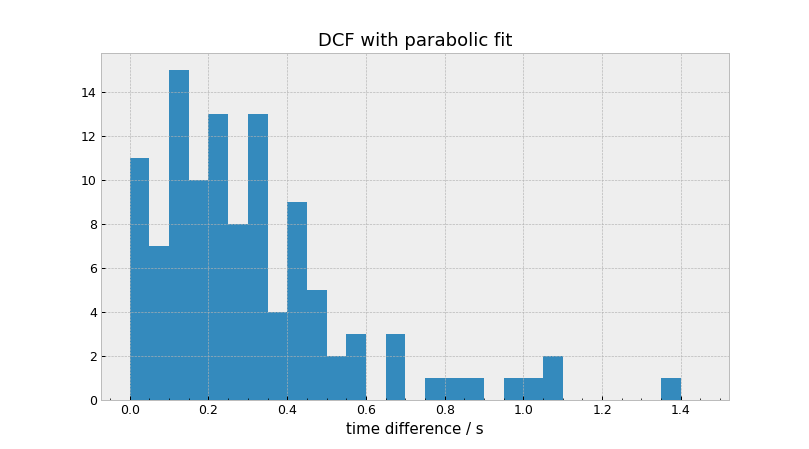

<IPython.core.display.Javascript object>


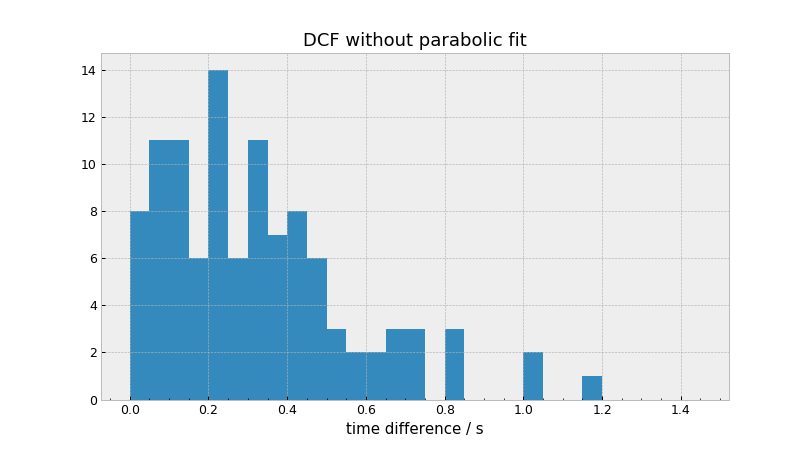

<IPython.core.display.Javascript object>


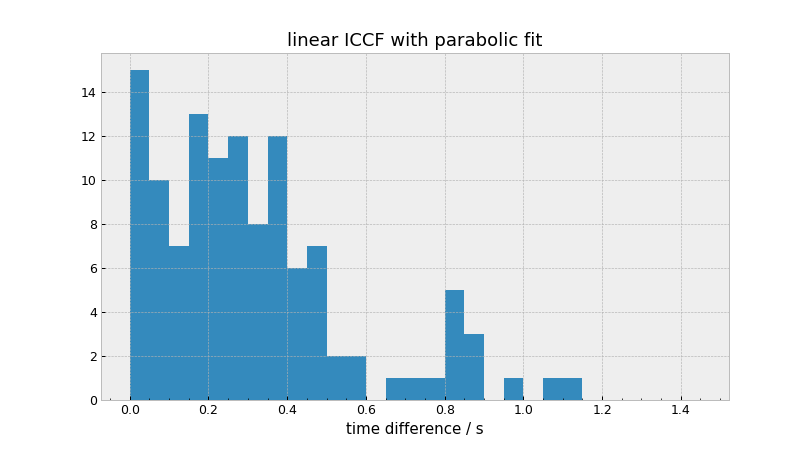

<IPython.core.display.Javascript object>


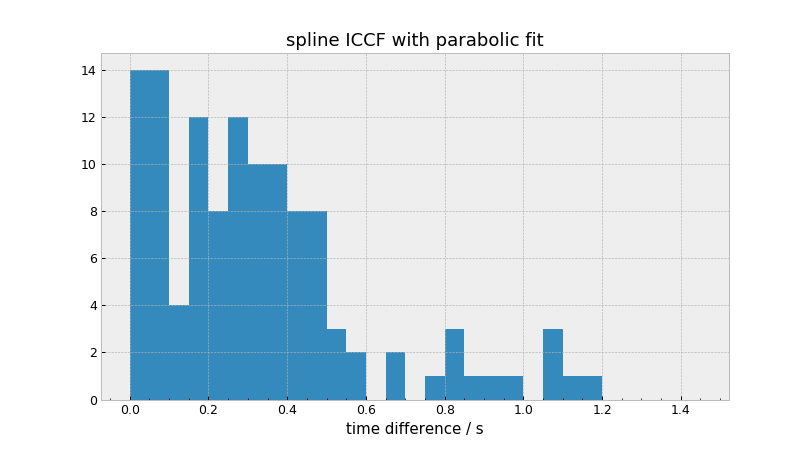

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


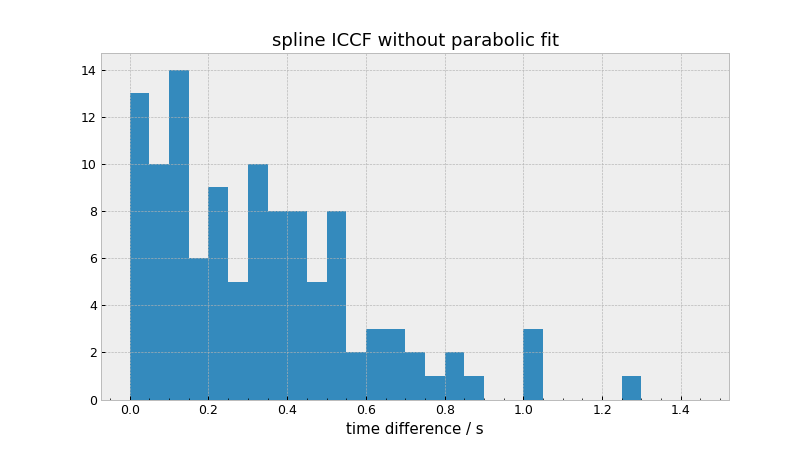

In [19]:
#analyze and plot found lag times

dts = np.array([maxim["dt"] for maxim in maxims])
dts_n = np.array([maxim["dtmax"] for maxim in maxims])
dts_i_lin = np.array([maxim["dt"] for maxim in maxims_i_lin])
dts_i_spl = np.array([maxim["dt"] for maxim in maxims_i_spl])
dts_i_lin_n = np.array([maxim["dtmax"] for maxim in maxims_i_lin])
dts_i_spl_n = np.array([maxim["dtmax"] for maxim in maxims_i_spl])

dts = np.absolute(dts)
dts_n = np.absolute(dts_n)
dts_i_lin = np.absolute(dts_i_lin)
dts_i_spl = np.absolute(dts_i_spl)
dts_i_lin_n = np.absolute(dts_i_lin_n)
dts_i_spl_n = np.absolute(dts_i_spl_n)

plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = [9, 5]
%matplotlib notebook
bins = np.arange(0, 1.5, 0.05)

figd, axsd = plt.subplots()
axsd.hist(dts, bins=bins)
axsd.set_xlabel('time difference / s')
axsd.xaxis.set_major_locator(MultipleLocator(0.2))
axsd.set_title('DCF with parabolic fit')
axsd.xaxis.set_minor_locator(AutoMinorLocator(4))
figd.savefig('timediff_d{}.pdf'.format(stepsize))

fig0, axs0 = plt.subplots()
axs0.hist(dts_n, bins=bins)
axs0.set_xlabel('time difference / s')
axs0.xaxis.set_major_locator(MultipleLocator(0.2))
axs0.set_title('DCF without parabolic fit')
axs0.xaxis.set_minor_locator(AutoMinorLocator(4))
fig0.savefig('timediff_d_no_fit{}.pdf'.format(stepsize))

fig1, axs1 = plt.subplots()
axs1.hist(dts_i_lin, bins=bins)
axs1.set_xlabel('time difference / s')
axs1.set_title('linear ICCF with parabolic fit')
axs1.xaxis.set_major_locator(MultipleLocator(0.2))
axs1.xaxis.set_minor_locator(AutoMinorLocator(4))
fig1.savefig('timediff_i_lin{}.pdf'.format(stepsize))

fig2, axs2 = plt.subplots()
axs2.hist(dts_i_spl, bins=bins)
axs2.set_xlabel('time difference / s')
axs2.set_title('spline ICCF with parabolic fit')
axs2.xaxis.set_major_locator(MultipleLocator(0.2))
axs2.xaxis.set_minor_locator(AutoMinorLocator(4))
fig2.savefig('timediff_i_spl{}.pdf'.format(stepsize))

fig3, axs3 = plt.subplots()
axs3.hist(dts_i_lin_n, bins=bins)
axs3.set_xlabel('time difference / s')
axs3.set_title('linear ICCF without parabolic fit')
axs3.xaxis.set_major_locator(MultipleLocator(0.2))
axs3.xaxis.set_minor_locator(AutoMinorLocator(4))
fig3.savefig('timediff_i_lin_no_fit{}.pdf'.format(stepsize))

fig4, axs4 = plt.subplots()
axs4.hist(dts_i_spl_n, bins=bins)
axs4.set_xlabel('time difference / s')
axs4.set_title('spline ICCF without parabolic fit')
axs4.xaxis.set_major_locator(MultipleLocator(0.2))
axs4.xaxis.set_minor_locator(AutoMinorLocator(4))
fig4.savefig('timediff_i_spl_no_fit{}.pdf'.format(stepsize))

<IPython.core.display.Javascript object>


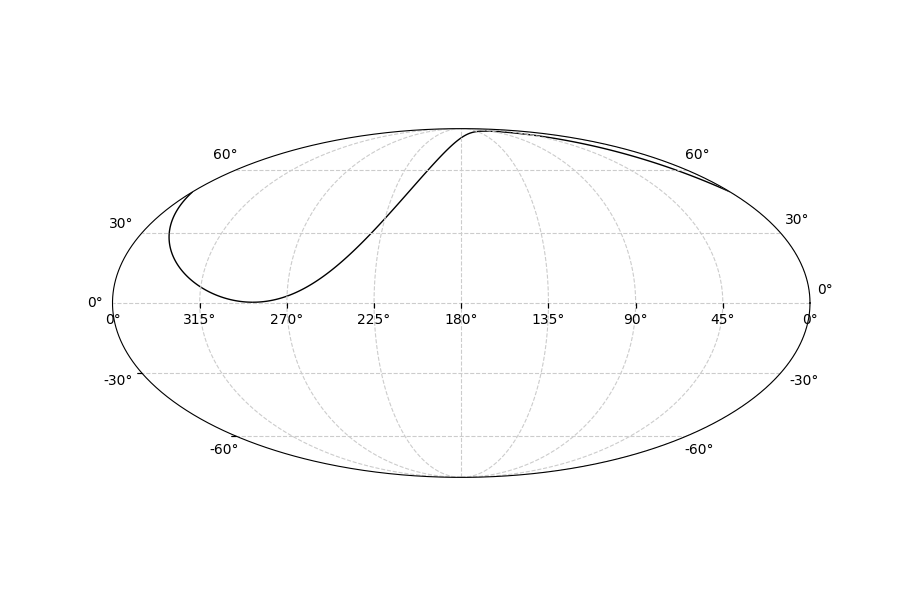

2018-01-10 14:35:59.218000
[0.                0.288431025410852]


<IPython.core.display.Javascript object>

2018-01-12 20:12:28.340000
[0.268607105310318 0.               ]


<IPython.core.display.Javascript object>


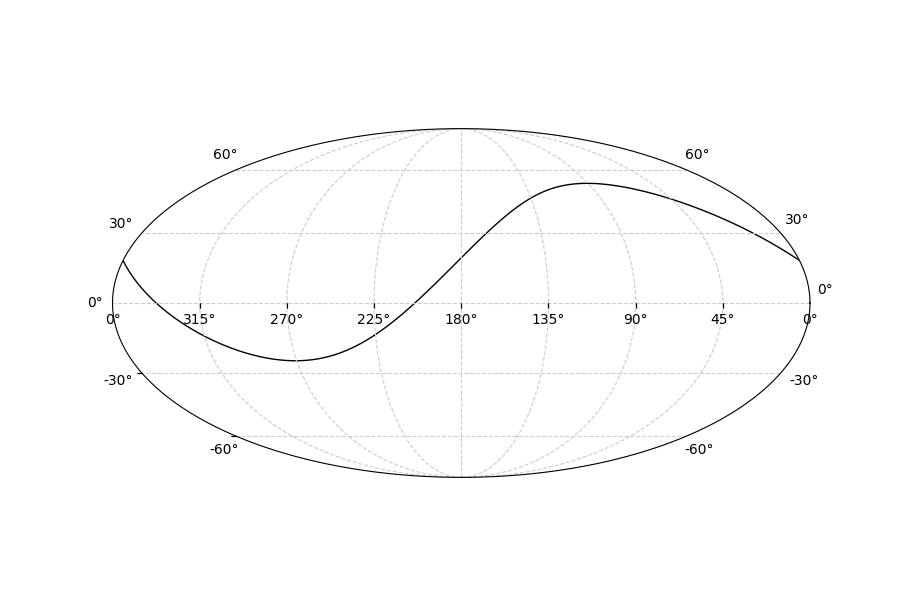

2018-01-13 00:16:00.471000
[0.                 0.1156785060028957]


<IPython.core.display.Javascript object>

2018-01-13 02:47:06.136000
[0.1511397775419914 0.                ]


<IPython.core.display.Javascript object>

2018-01-13 10:02:05.407000
[0.                 0.3662894298091982]


<IPython.core.display.Javascript object>


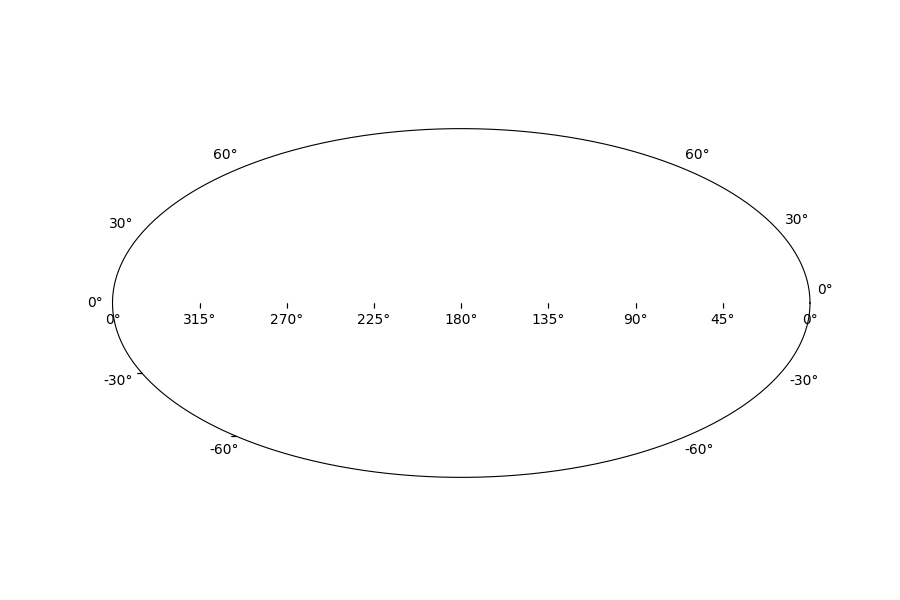

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


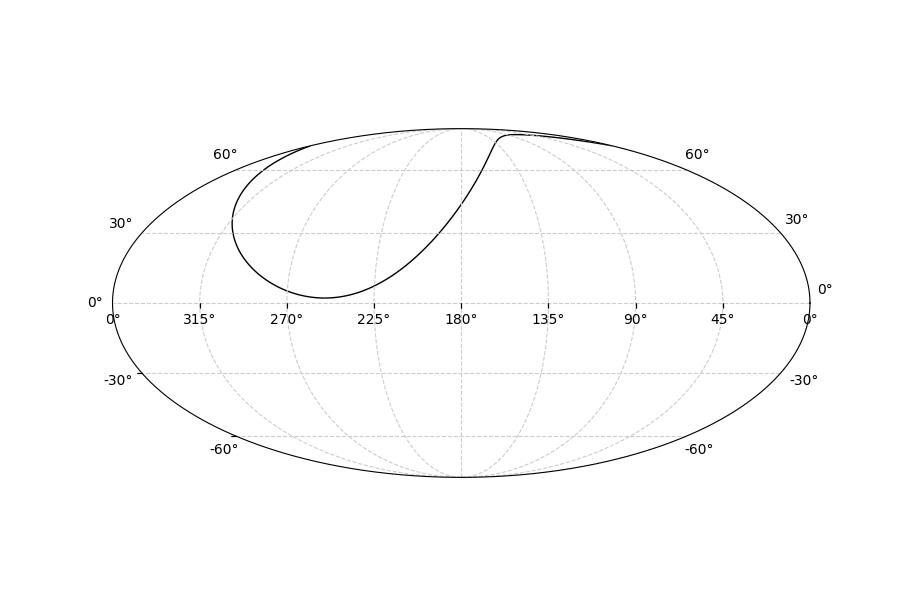

2018-02-18 15:14:05.488000
[0.                 0.3163388315233418]


<IPython.core.display.Javascript object>


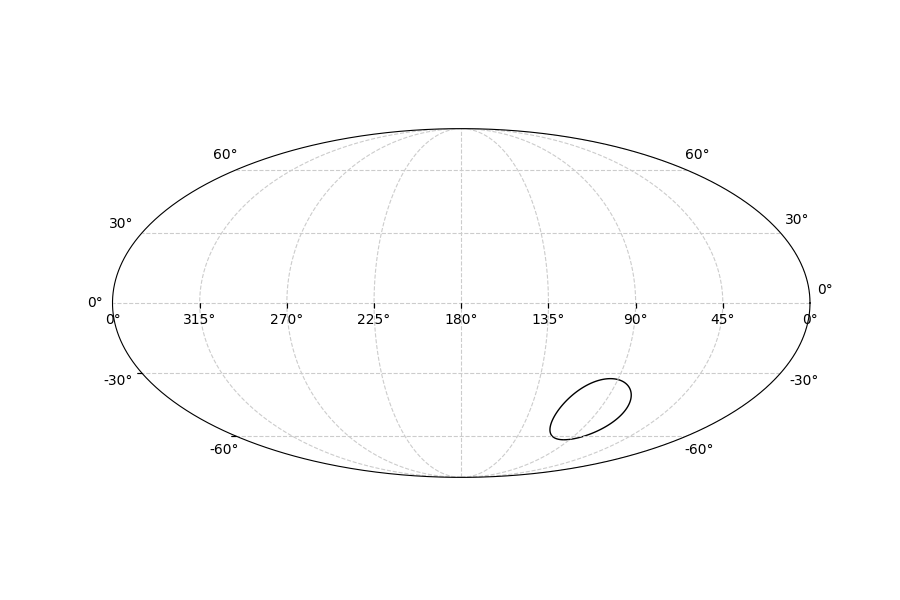

2018-02-27 05:04:16.561000
[0.4566222587900762 0.                ]


<IPython.core.display.Javascript object>


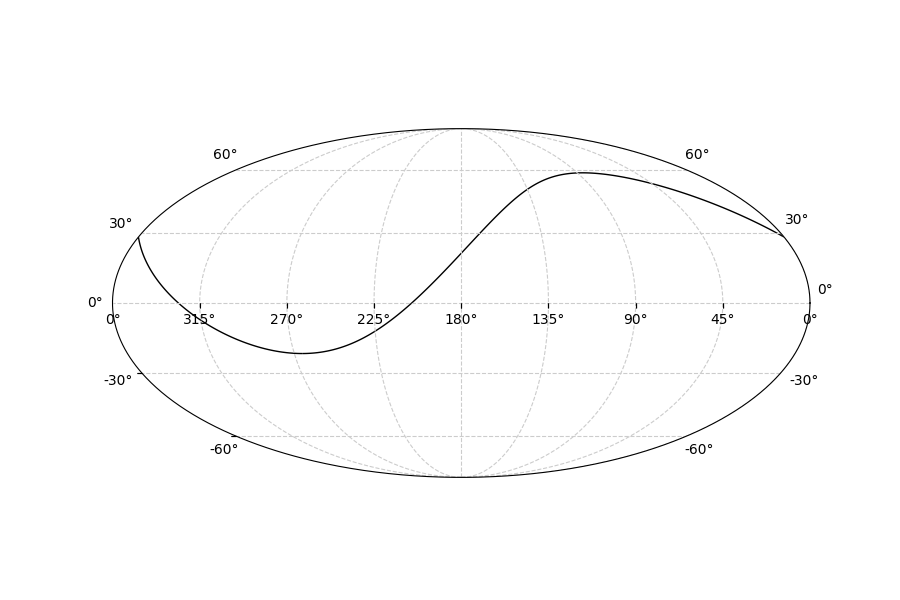

2018-03-30 21:23:15.522000
[0.                 0.1565020340207128]


<IPython.core.display.Javascript object>


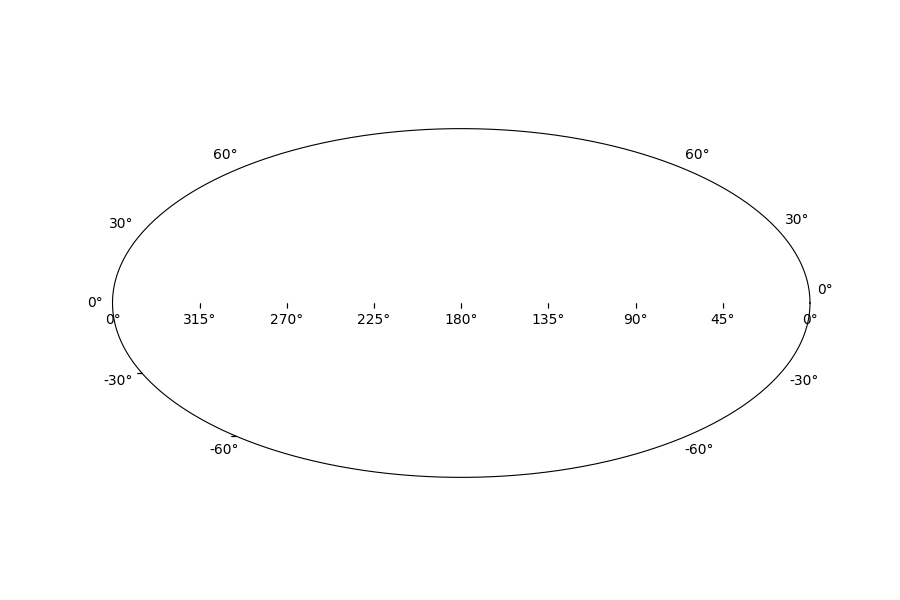

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>

2018-04-02 09:44:59.367000
[0.                 0.1816740172334805]


<IPython.core.display.Javascript object>


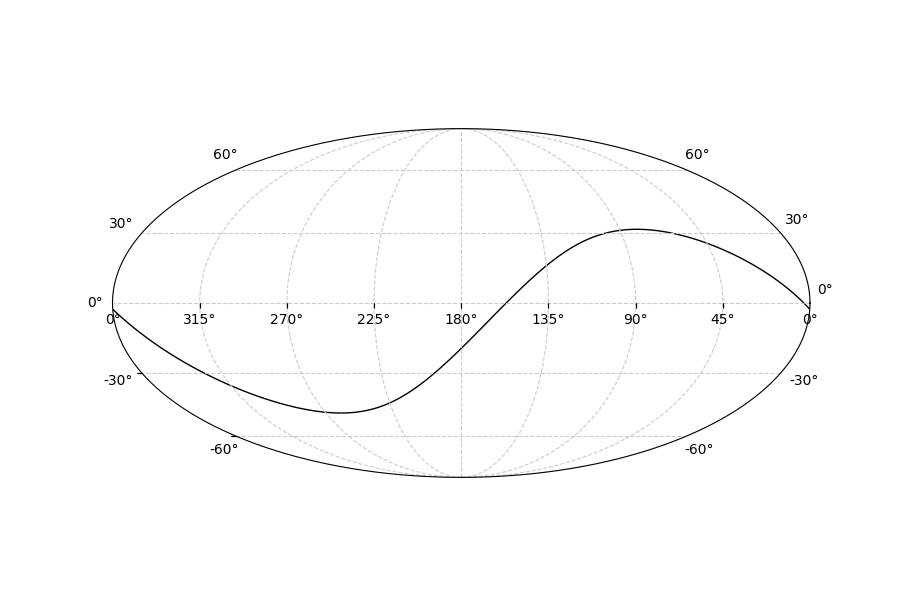

2018-04-02 11:32:11.626000
[0.06989997809853 0.              ]


<IPython.core.display.Javascript object>


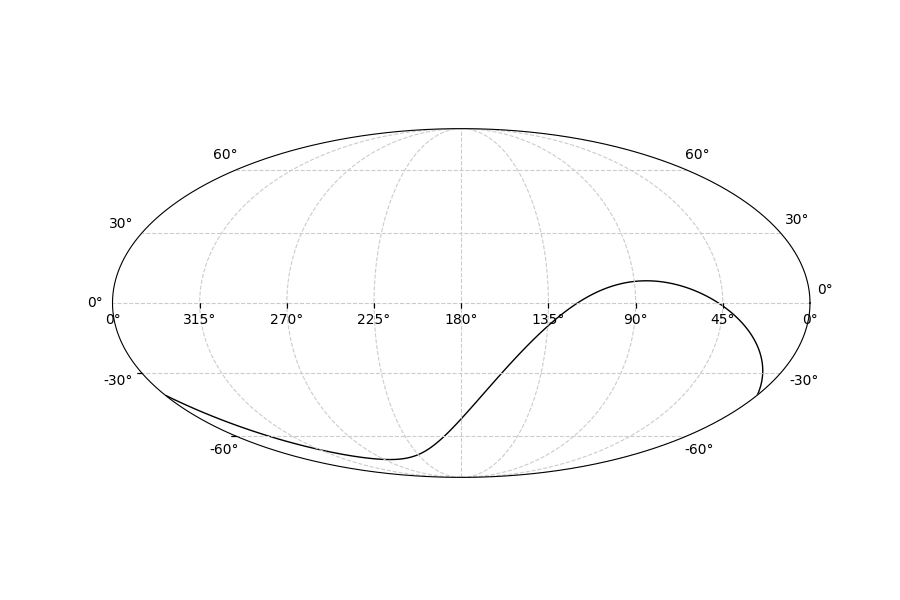

2018-04-05 04:02:53.061000
[0.2737261962710845 0.                ]


<IPython.core.display.Javascript object>


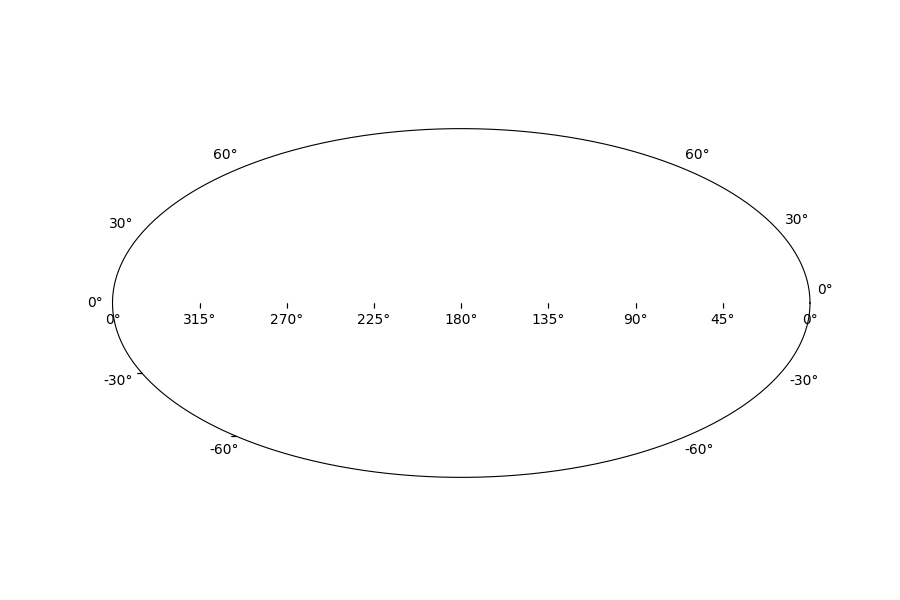

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


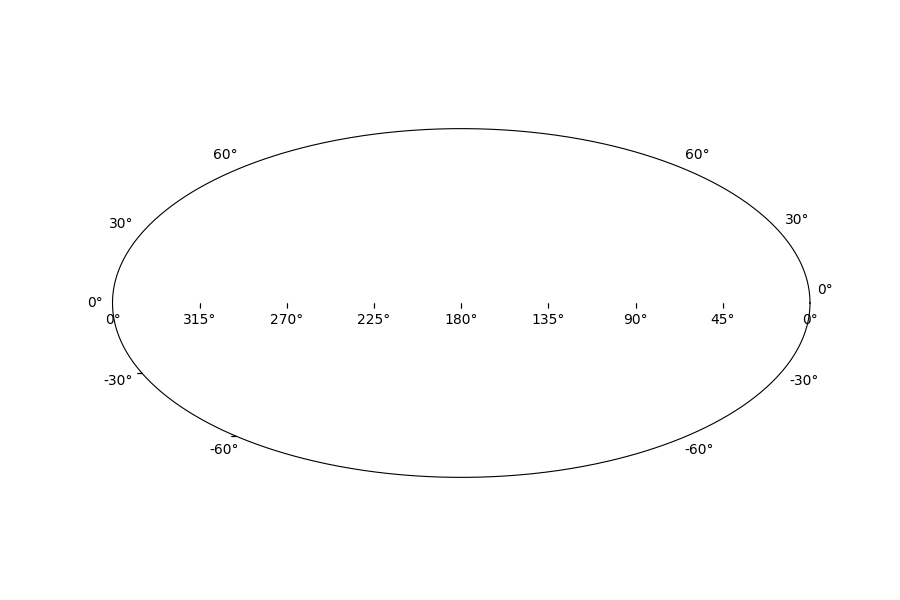

angle theta is nan, given positions or dt is probably wrong


<IPython.core.display.Javascript object>


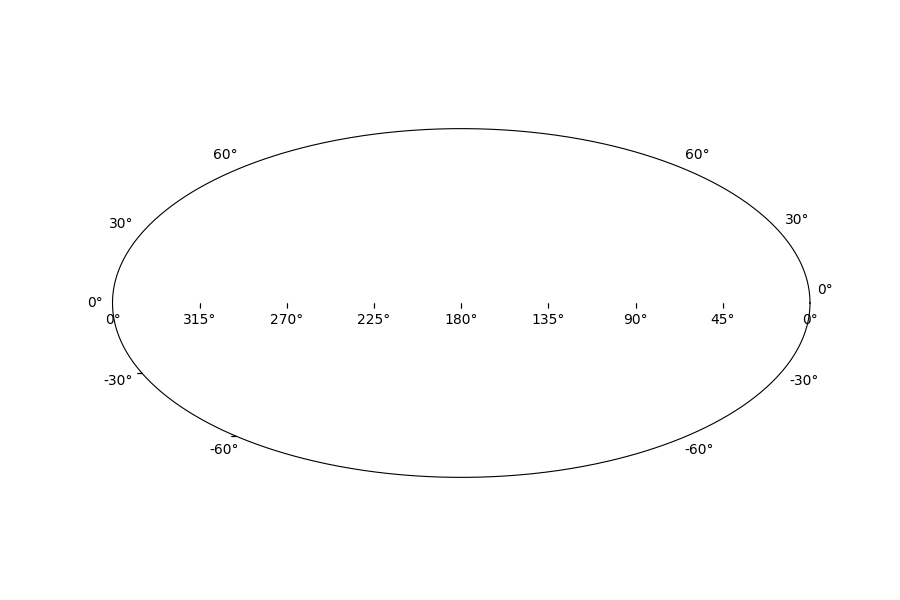

angle theta is nan, given positions or dt is probably wrong


<IPython.core.display.Javascript object>


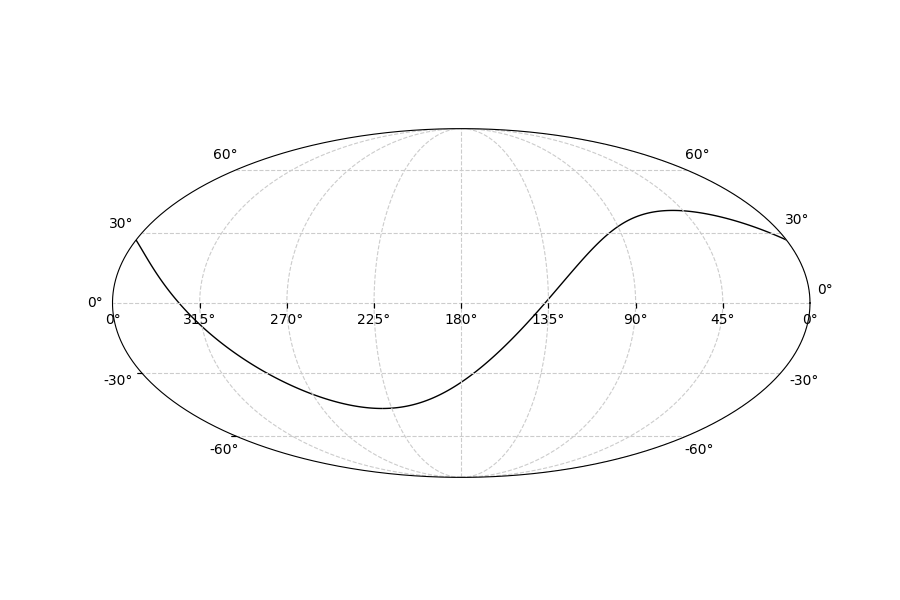

2018-04-17 16:32:45.654000
[0.0208331921441678 0.                ]


<IPython.core.display.Javascript object>


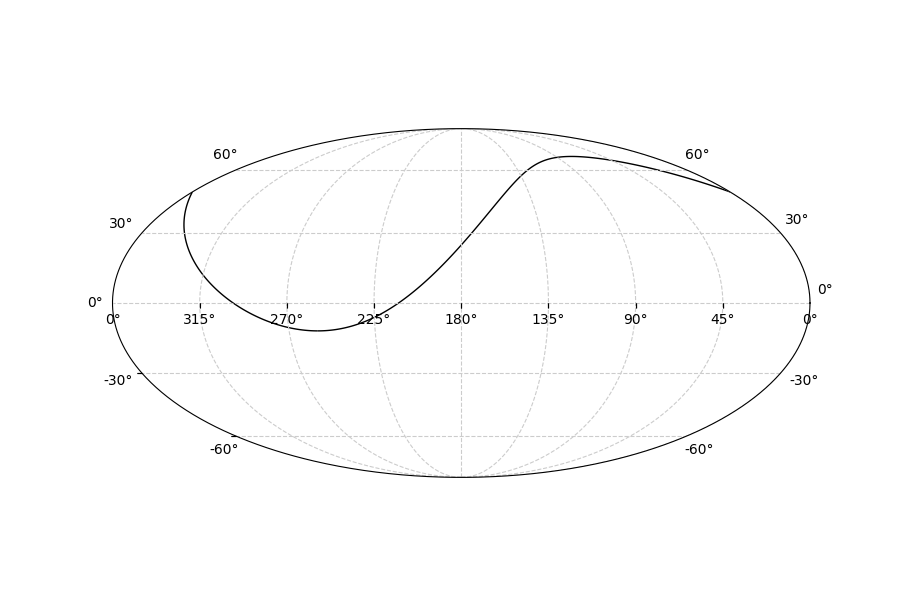

2018-04-18 06:44:06.282000
[0.                 0.2258171534480444]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


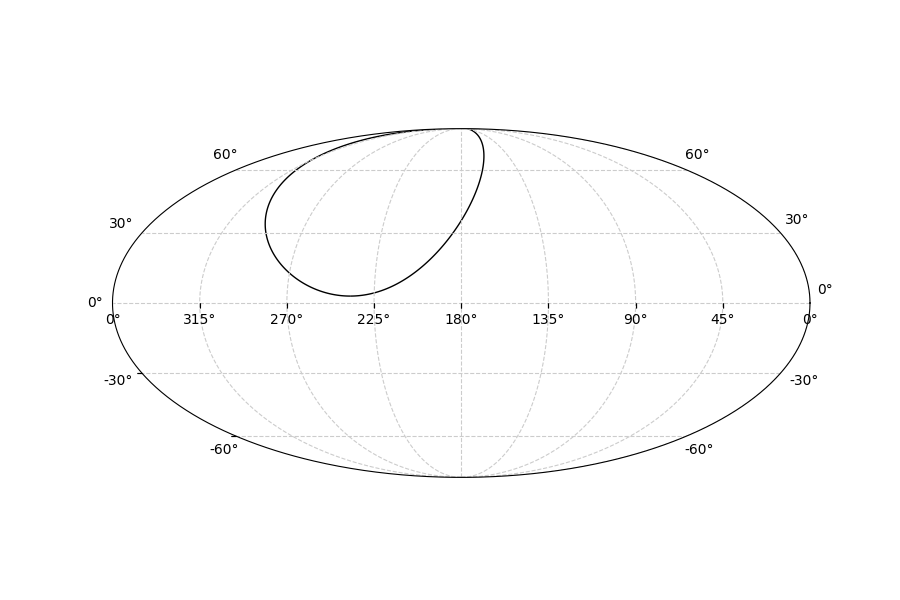

2018-04-23 00:47:03.657000
[0.                 0.2870154316045208]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


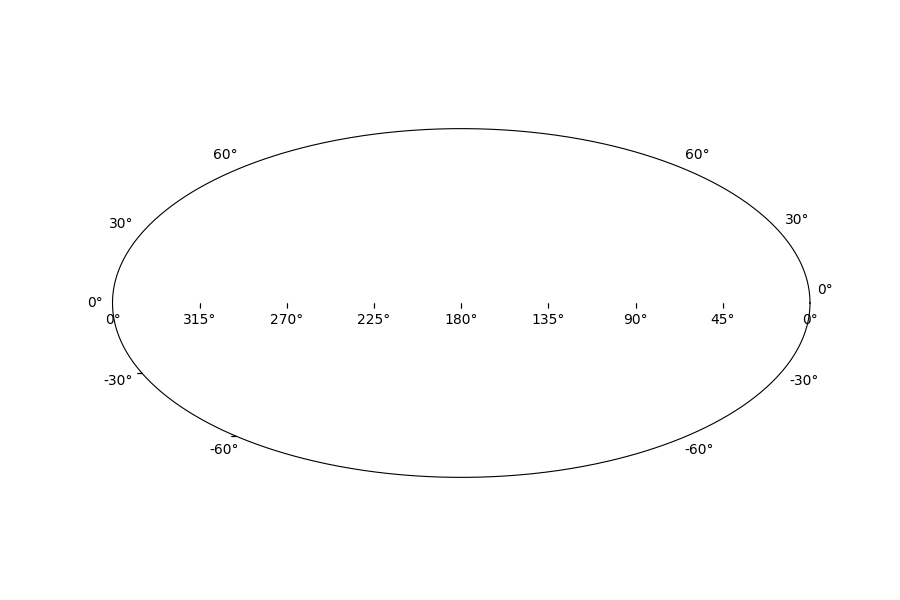

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


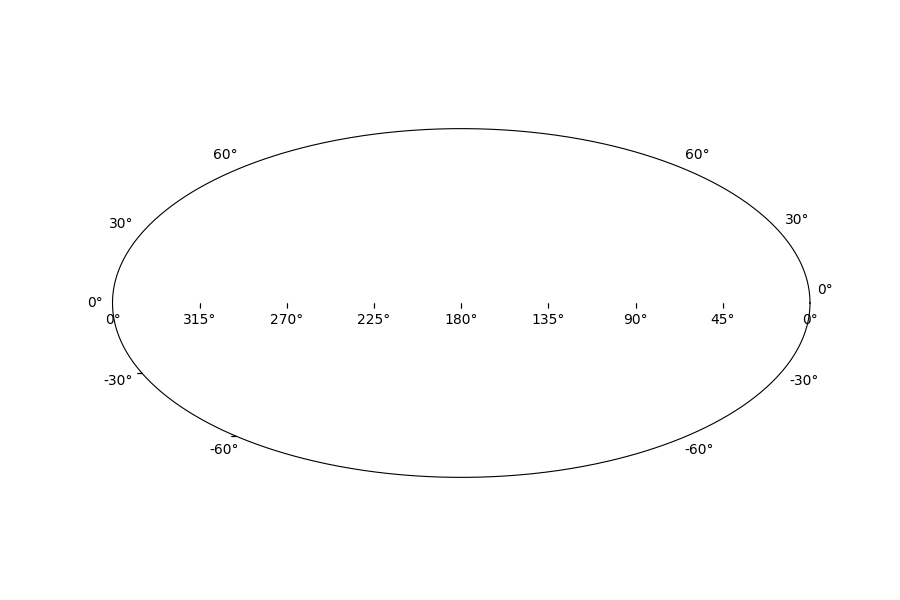

angle theta is nan, given positions or dt is probably wrong


<IPython.core.display.Javascript object>


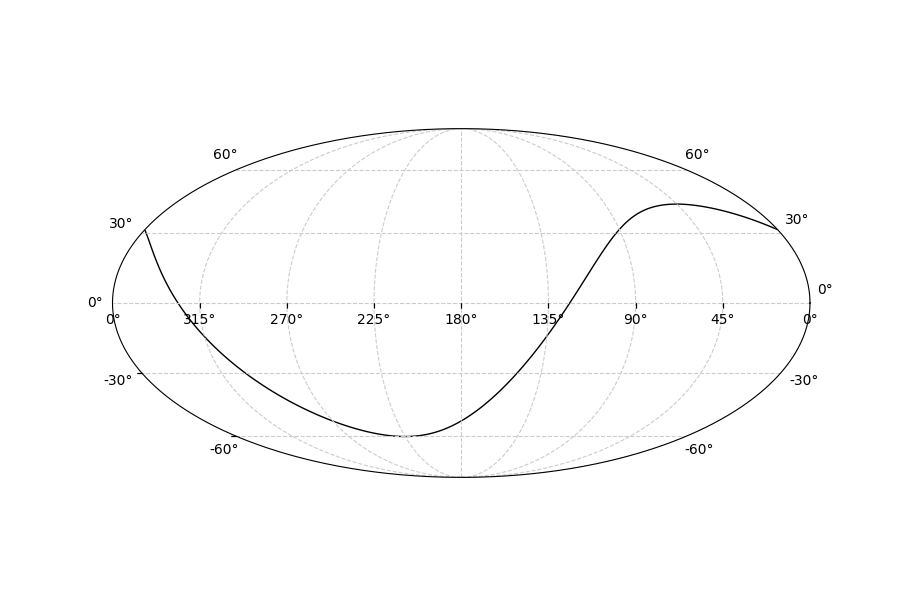

2018-04-28 02:27:15.309000
[0.0506770444294099 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


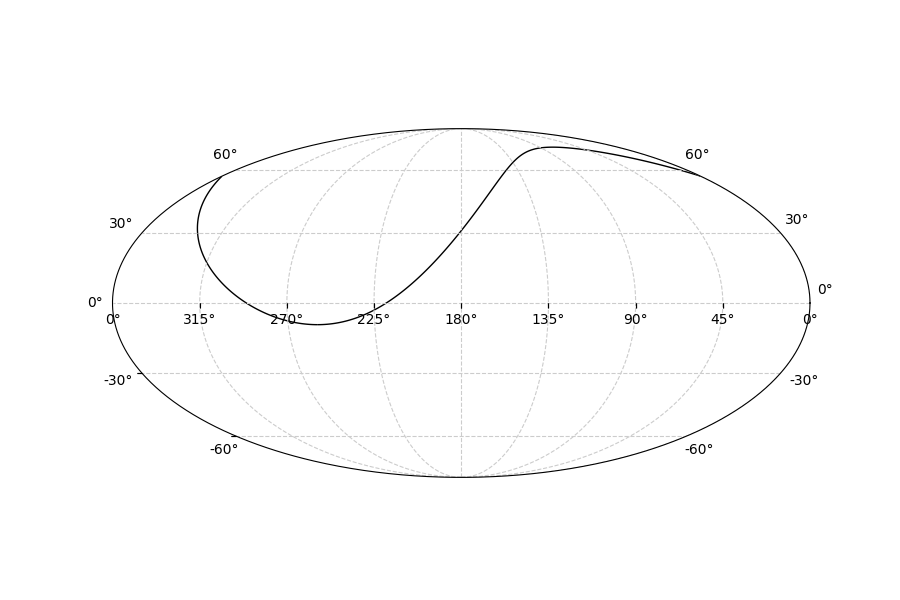

2018-05-04 03:15:53.830000
[0.                 0.2630988956287477]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-05-11 08:43:35.786000
[0.                0.216776366552317]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


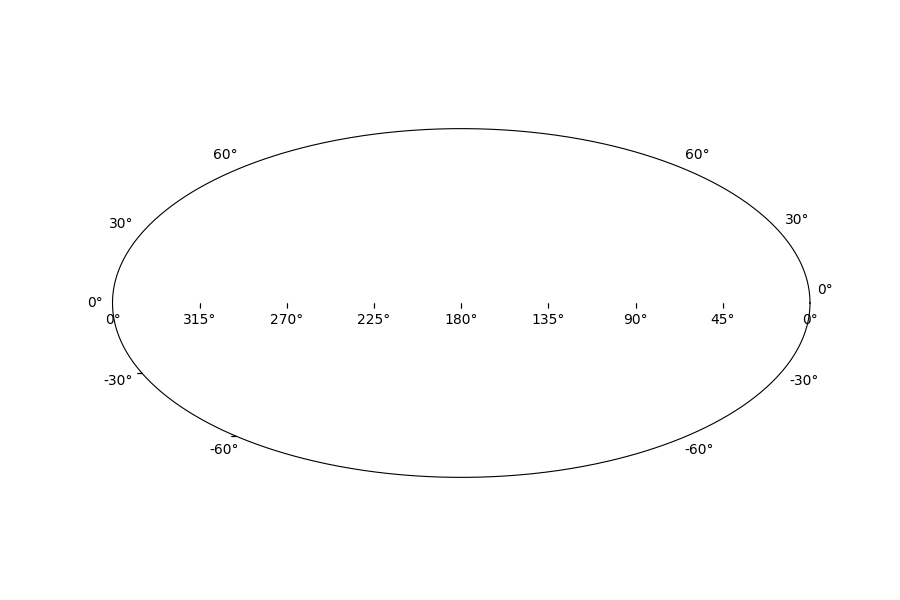

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


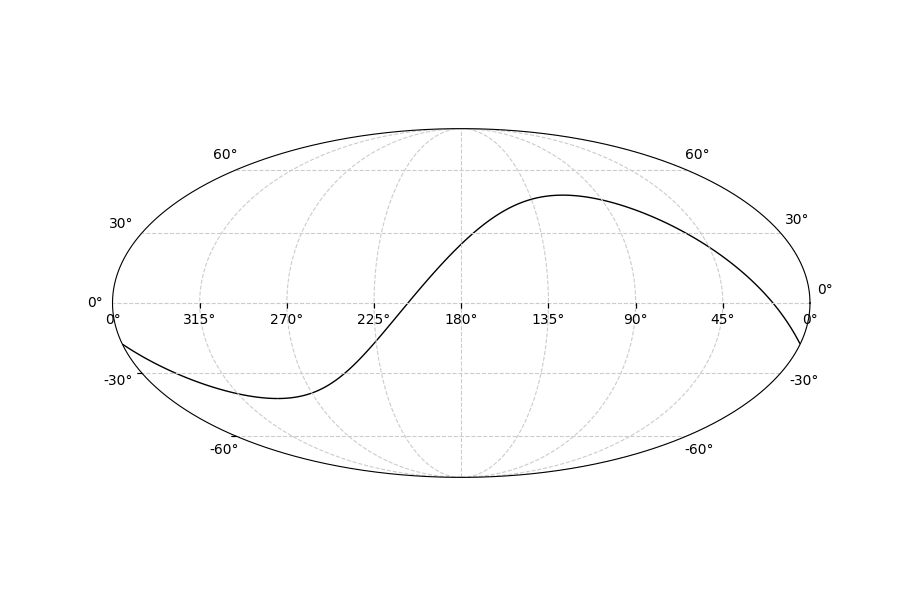

2018-05-23 18:46:28.107000
[0.               0.01786584318051]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


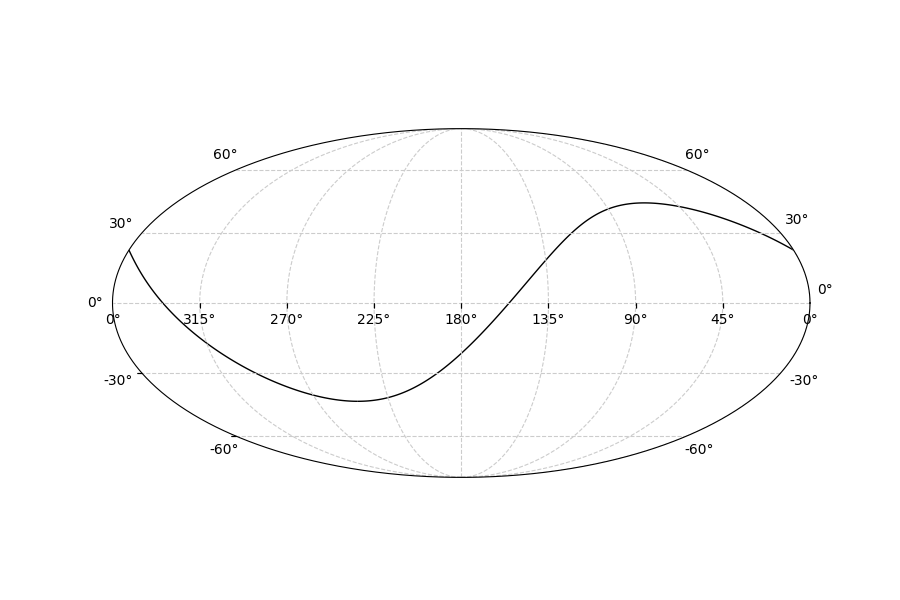

2018-05-25 03:37:59.082000
[0.                 0.0035503562793418]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-06-05 10:59:25.177000
[0.3810931404230217 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


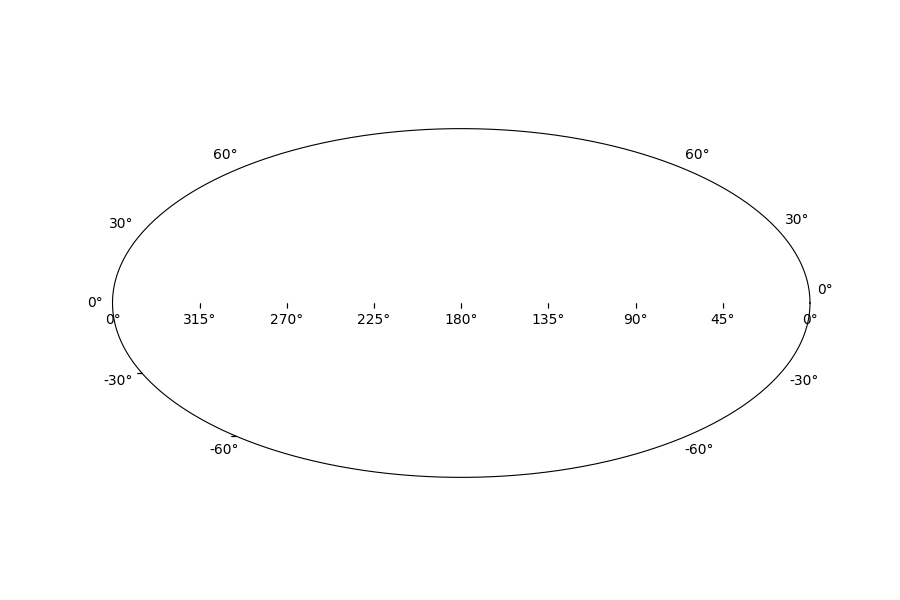

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


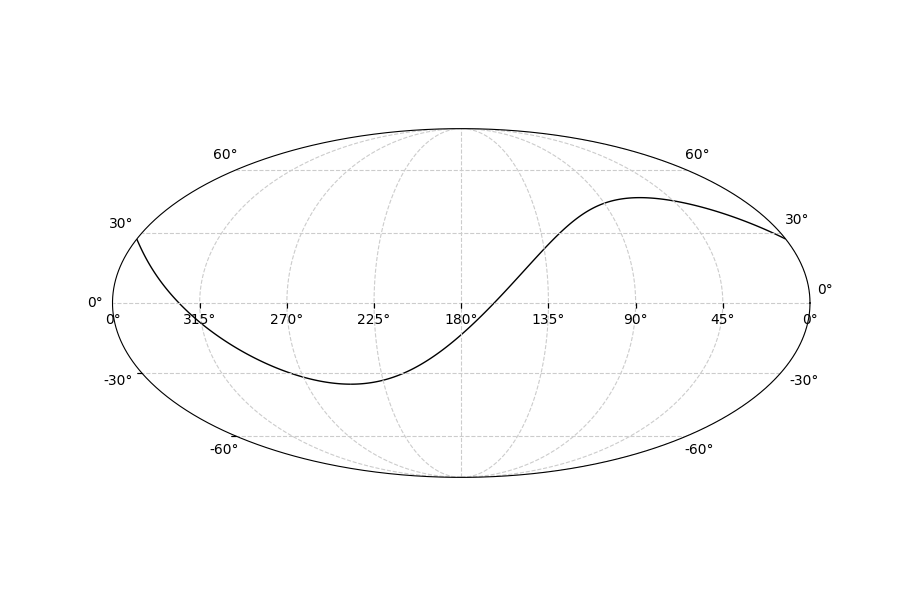

2018-06-15 11:05:56.316000
[0.                 0.0444160718848849]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


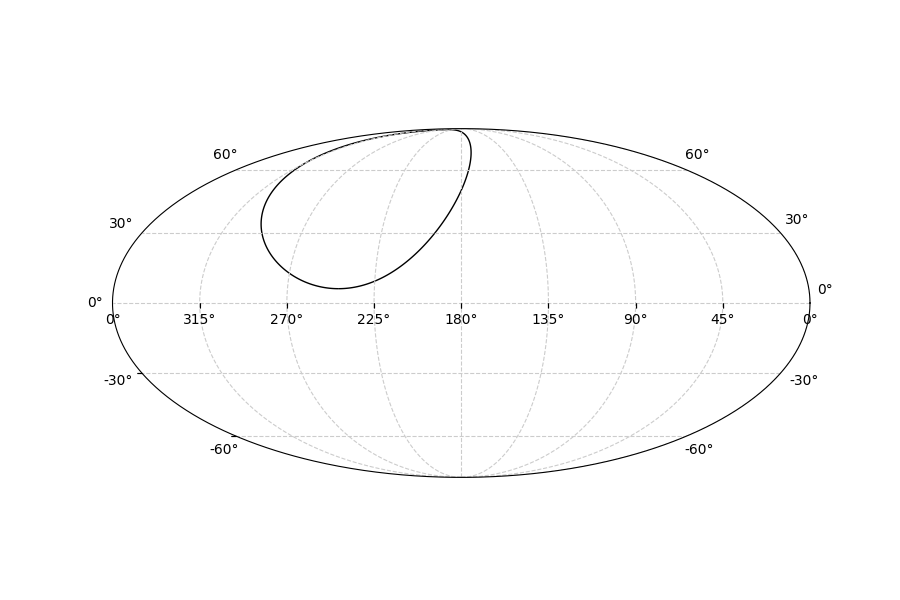

2018-06-18 00:43:13.115000
[0.                 0.3342964769325175]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


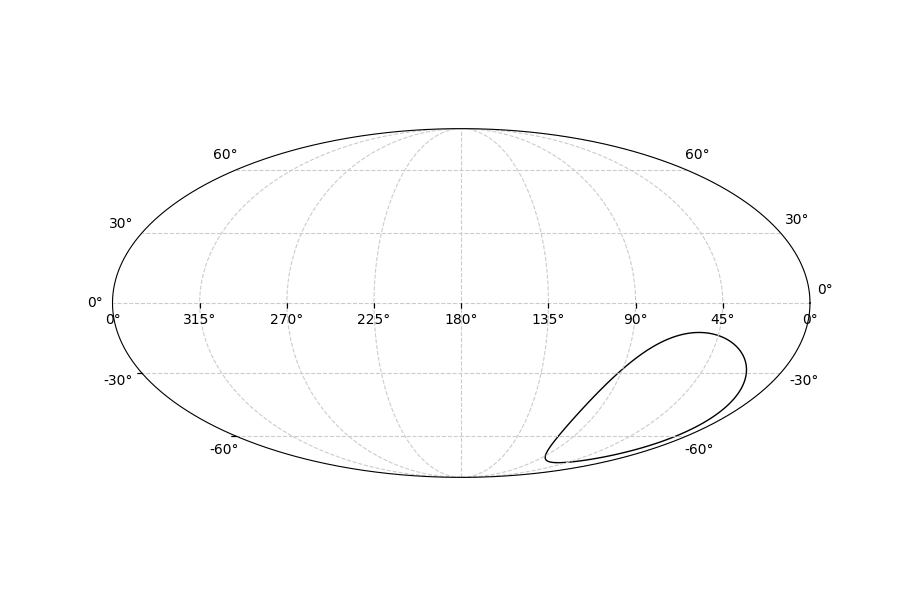

2018-06-25 22:34:41.709000
[0.3795769761894963 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


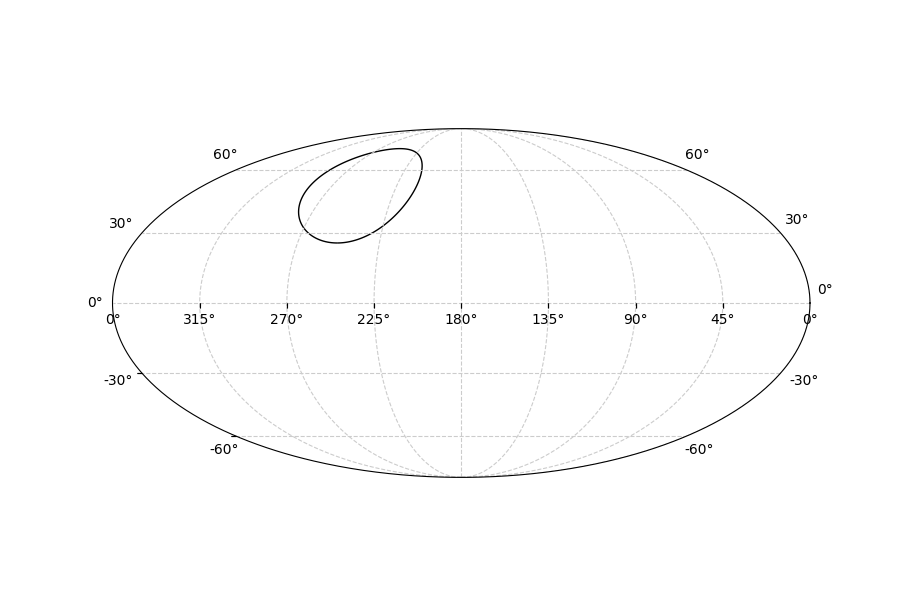

2018-06-26 09:23:50.648000
[0.                 0.4558525732038526]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


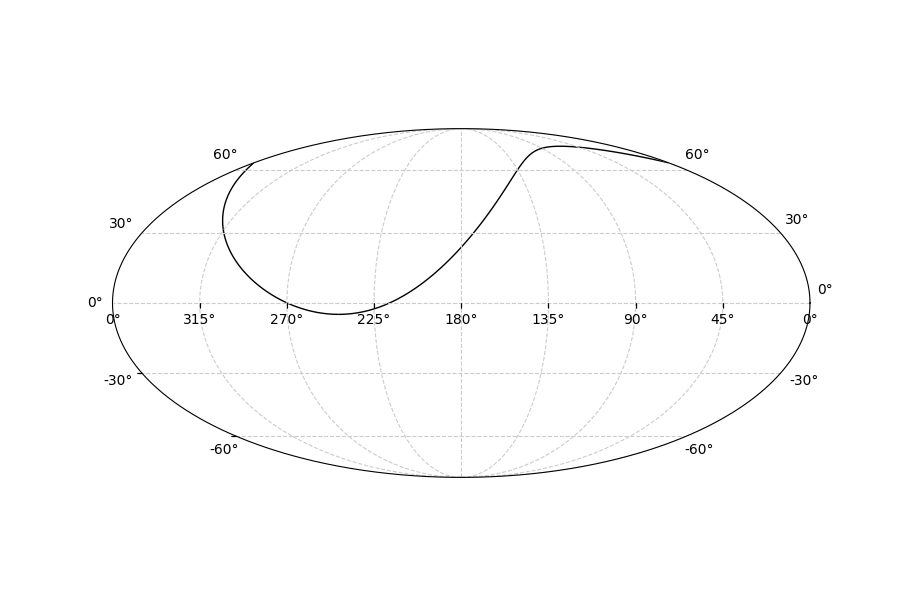

2018-07-01 11:15:04.510000
[0.                 0.2671919764136278]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


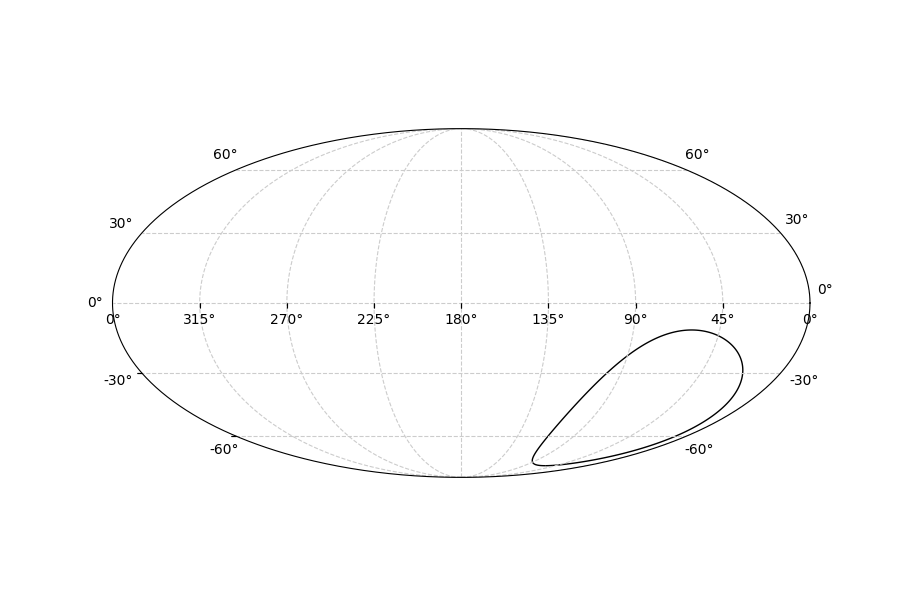

2018-07-03 22:46:51.317000
[0.3817345932747167 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


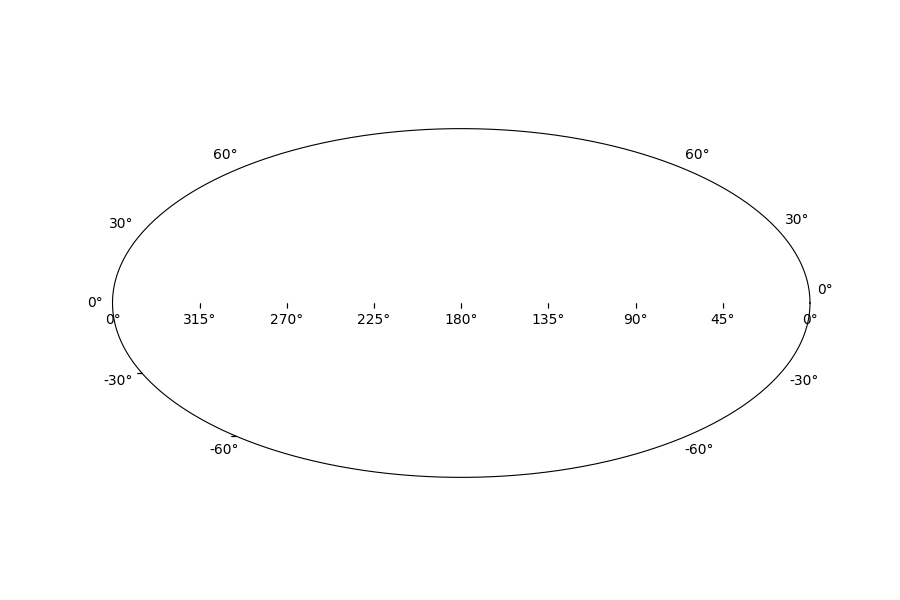

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


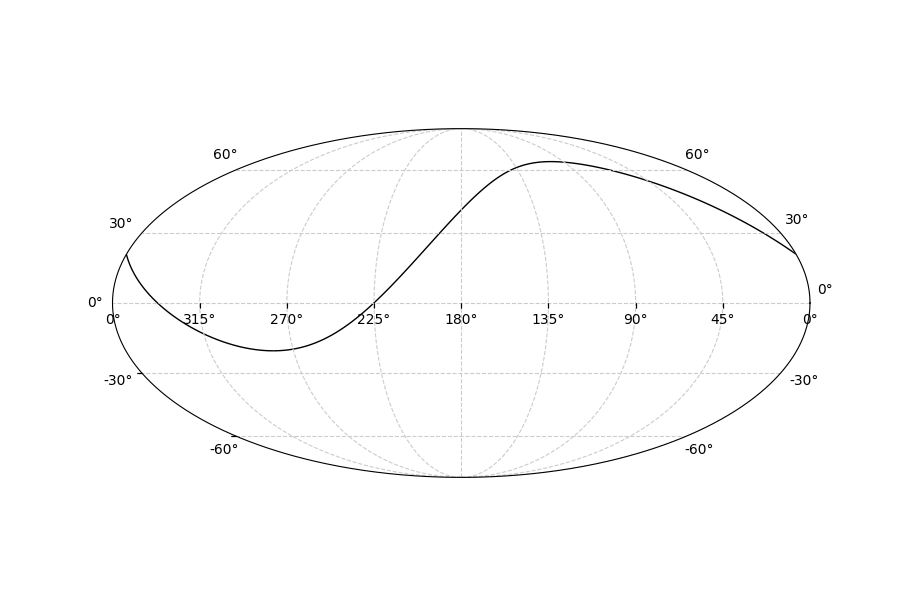

2018-07-15 17:47:19.091000
[0.                 0.1595774878772916]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


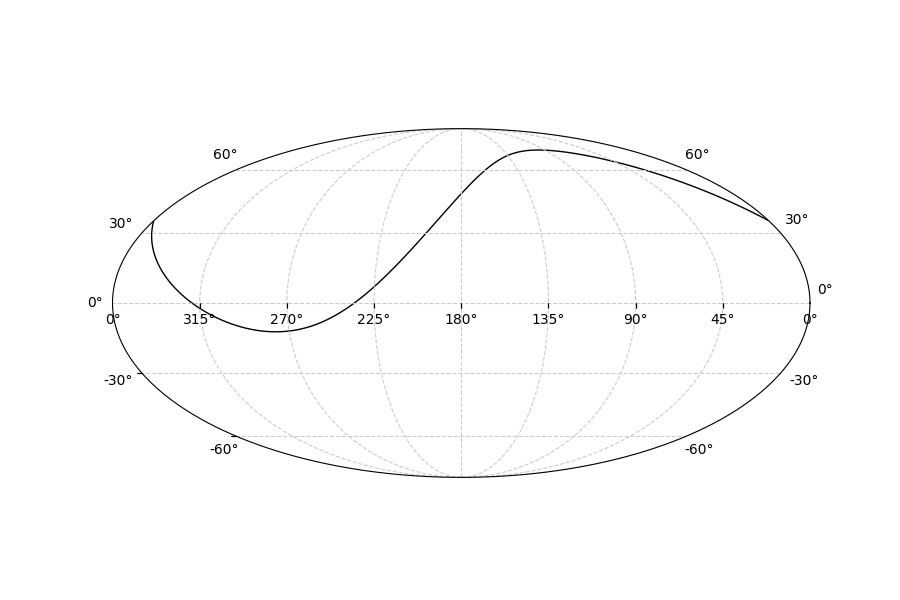

2018-07-15 18:07:05.061000
[0.                 0.1988480265963585]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


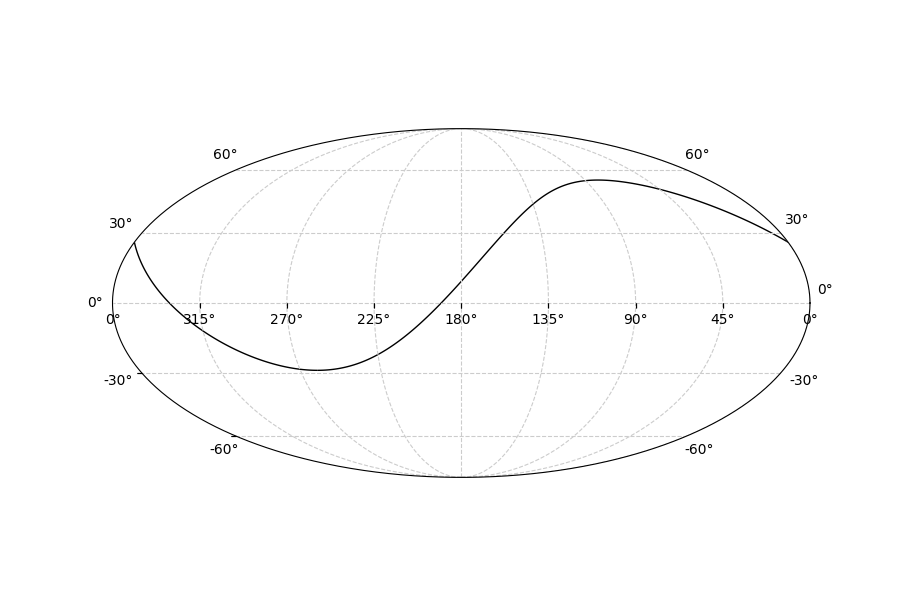

2018-07-18 01:57:44.601000
[0.                0.108855714386817]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


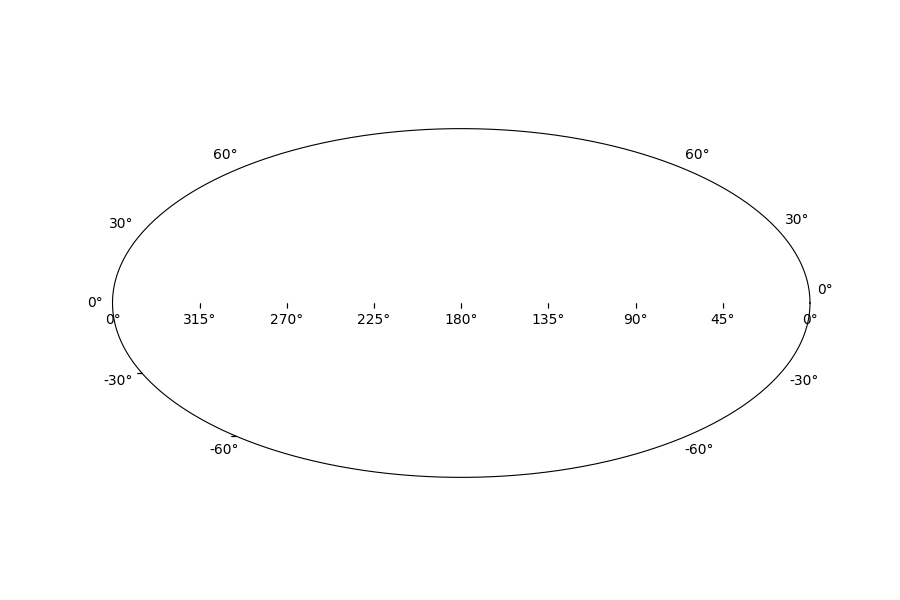

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


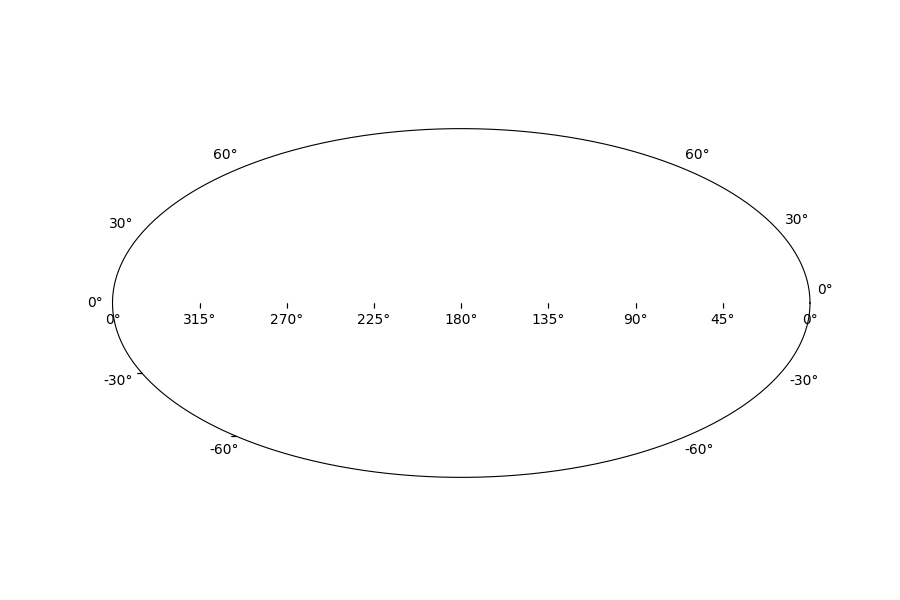

angle theta is nan, given positions or dt is probably wrong


<IPython.core.display.Javascript object>


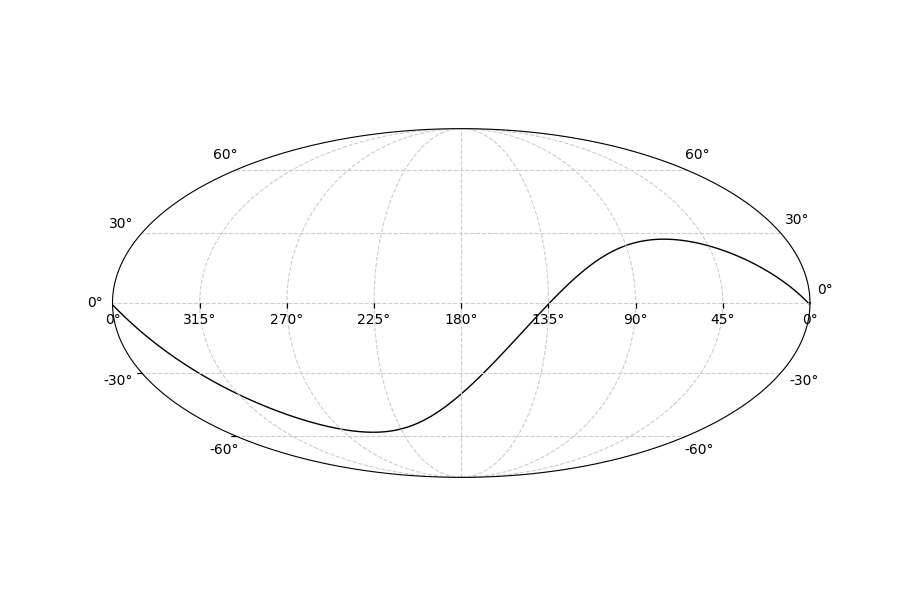

2018-07-20 05:06:02.058000
[0.1367548882792538 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


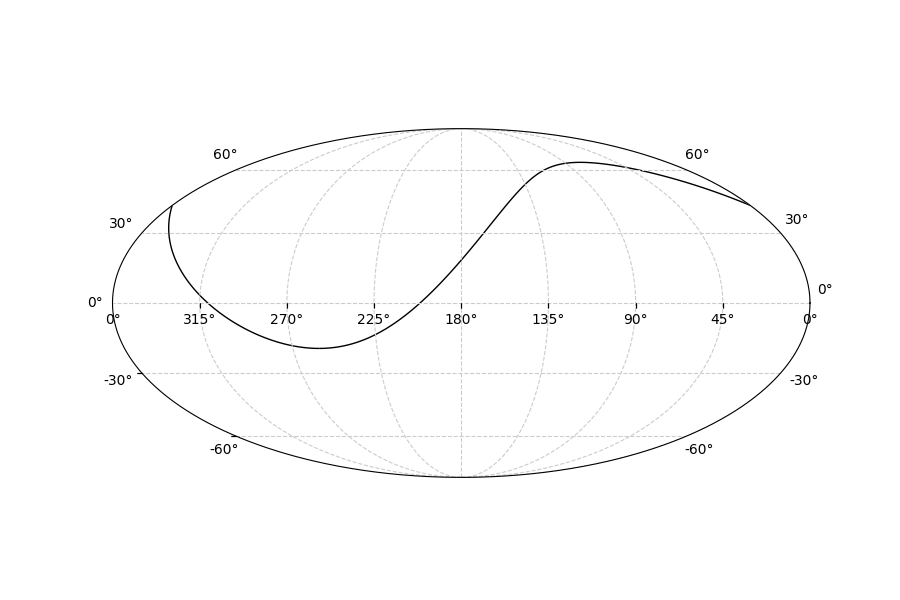

2018-07-20 14:21:39.654000
[0.                 0.1940702345360798]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-07-23 18:09:48.161000
[0.2049812059254446 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-07-28 17:29:02.277000
[0.               0.09269524287206]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


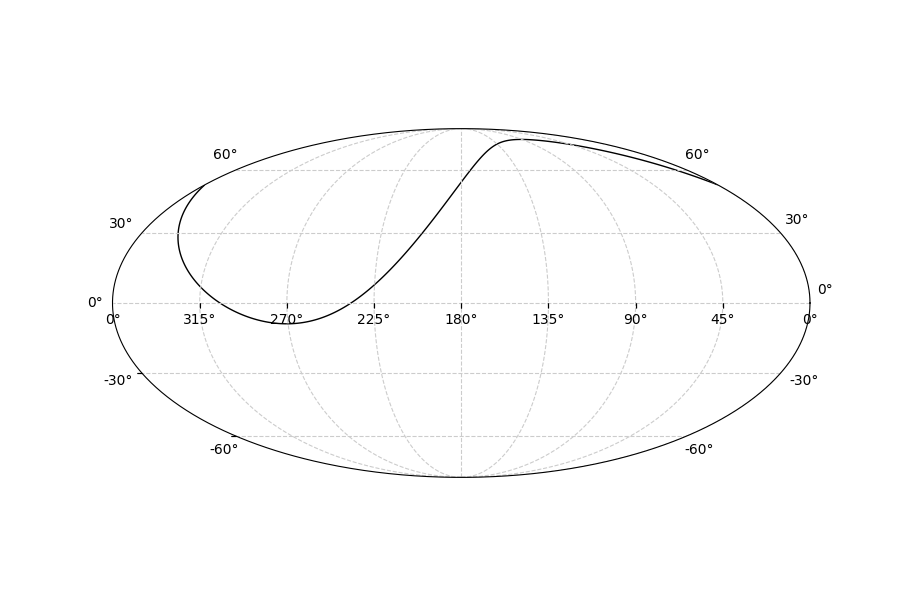

2018-07-28 21:09:58.913000
[0.                 0.2761429933509675]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


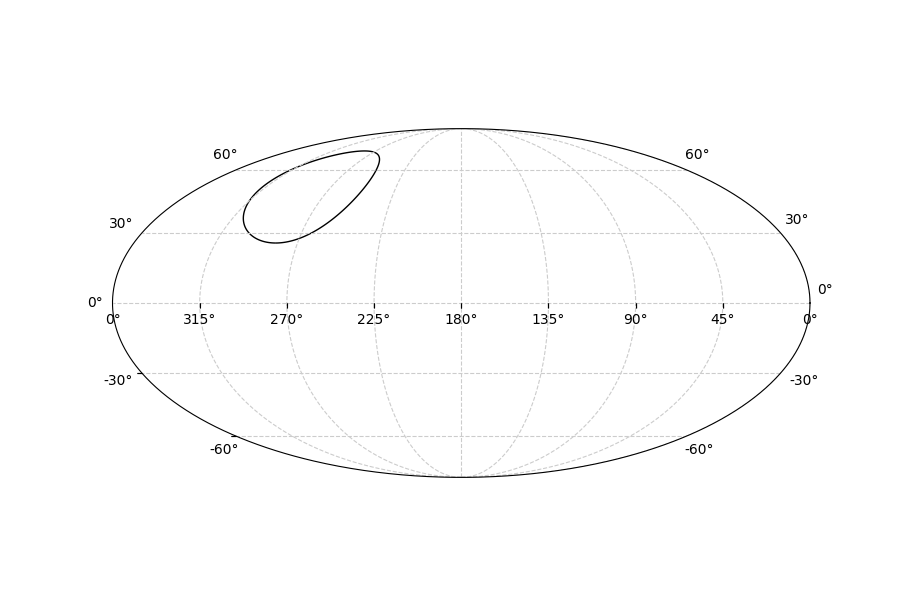

2018-07-31 21:23:21.639000
[0.                 0.3350075880373961]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


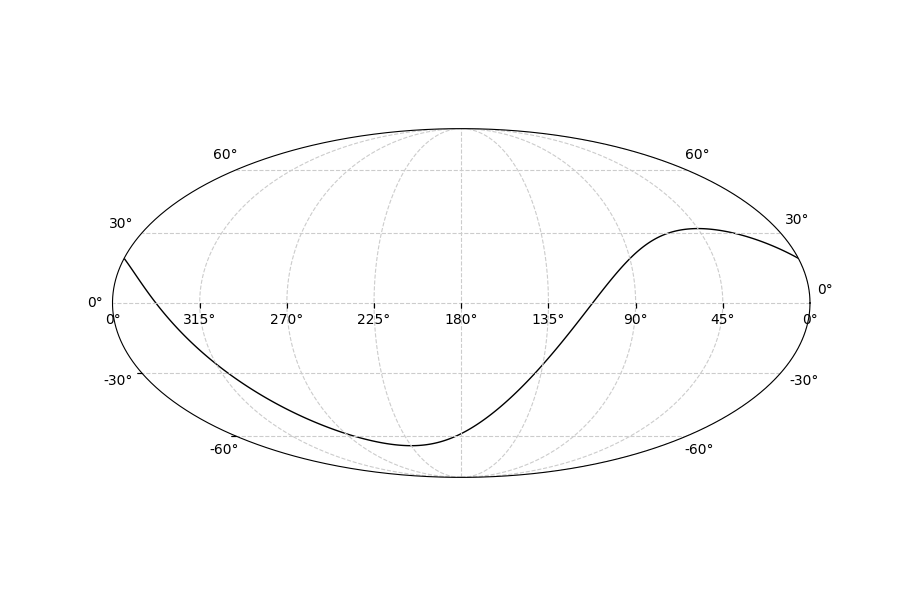

2018-08-04 13:17:41.437000
[0.102977475715905 0.               ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


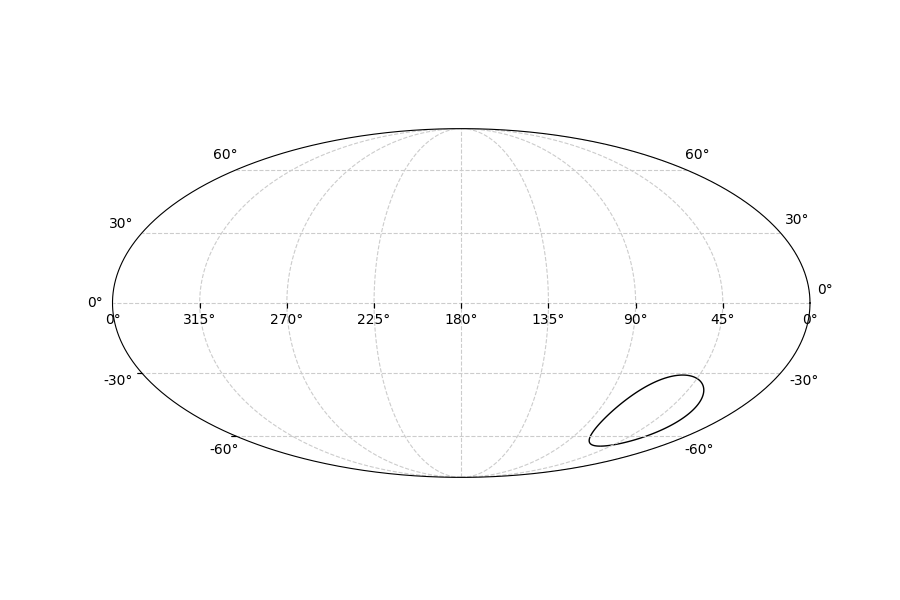

2018-08-04 22:20:38.284000
[0.4413444624606747 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


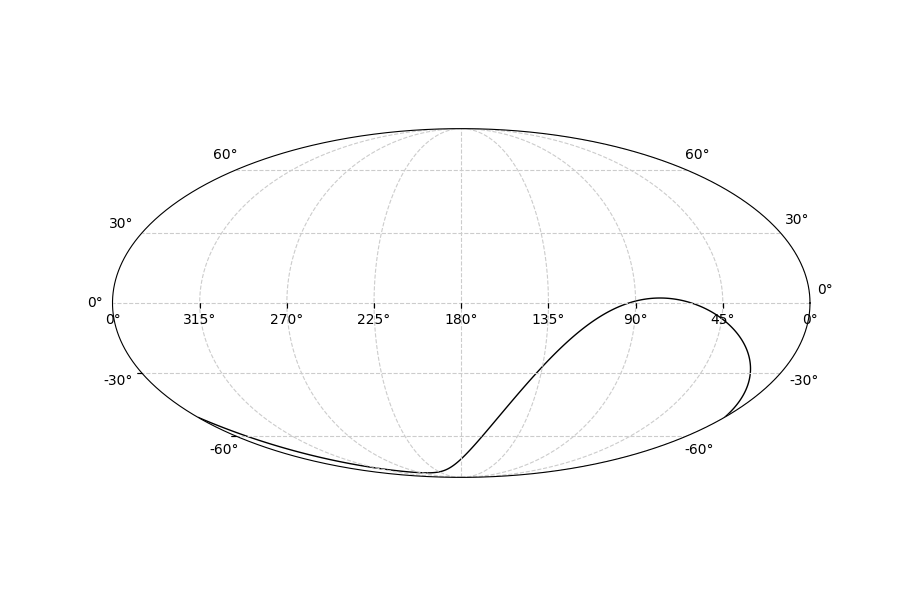

2018-08-05 13:02:36.516000
[0.3382901176115234 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


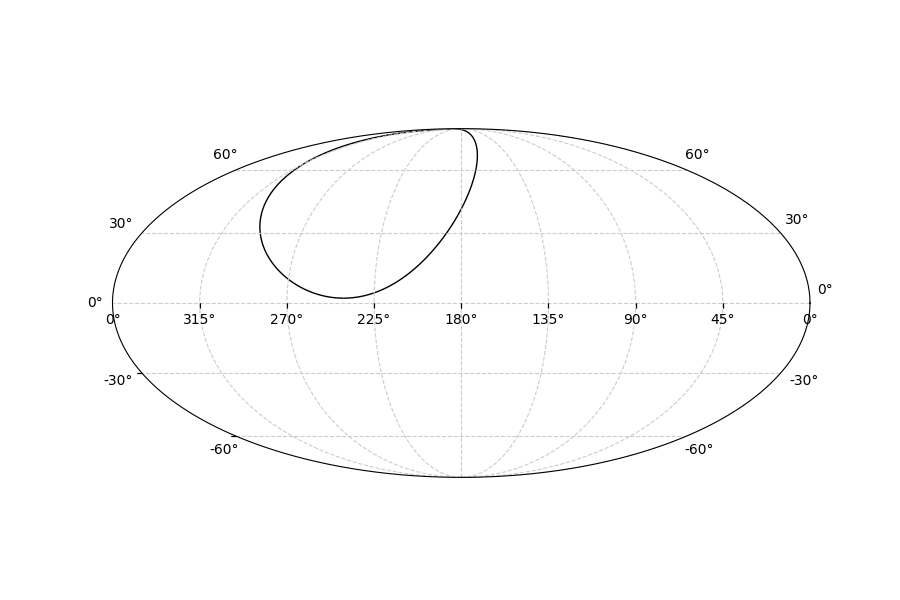

2018-08-18 04:17:57.030000
[0.                 0.3309278228248546]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


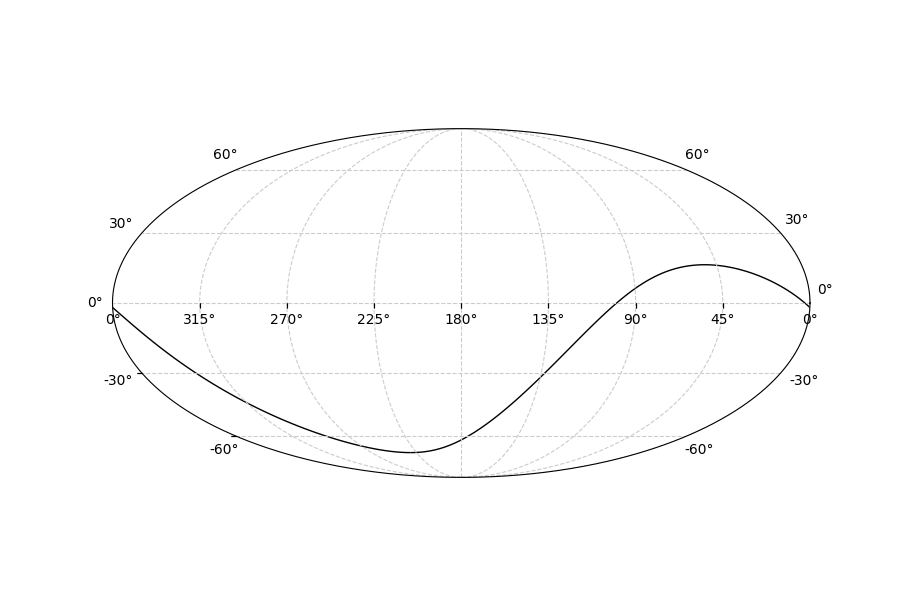

2018-08-23 10:36:38.228000
[0.1966634880987931 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


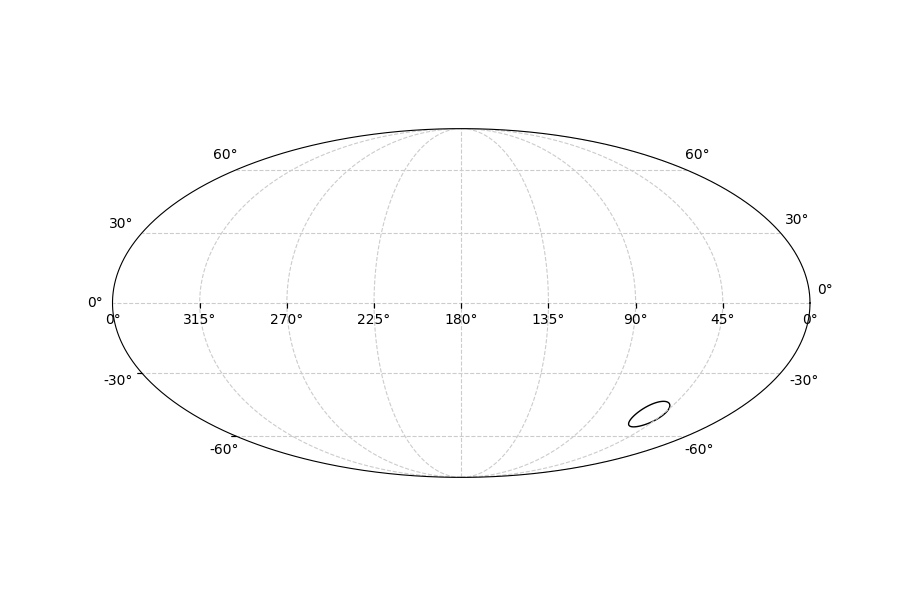

2018-08-28 18:57:26.577000
[0.4318482015270245 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


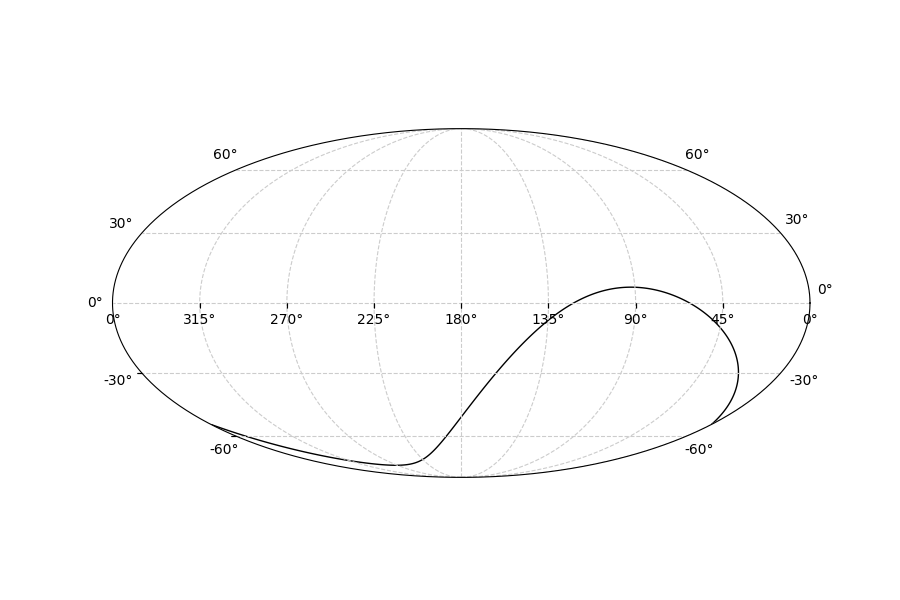

2018-09-06 18:12:25.937000
[0.2766967253182848 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


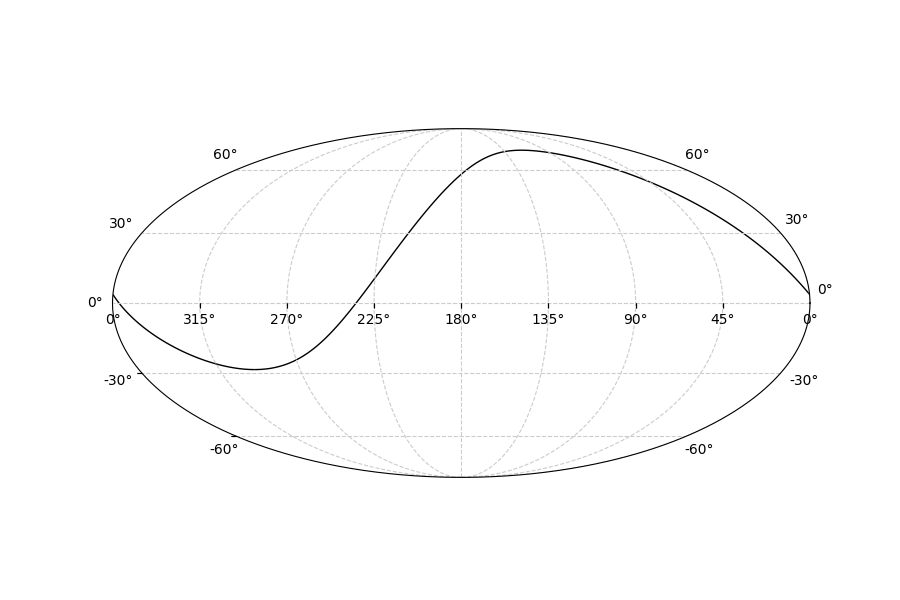

2018-09-10 00:46:12.985000
[0.                 0.0841234517199217]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


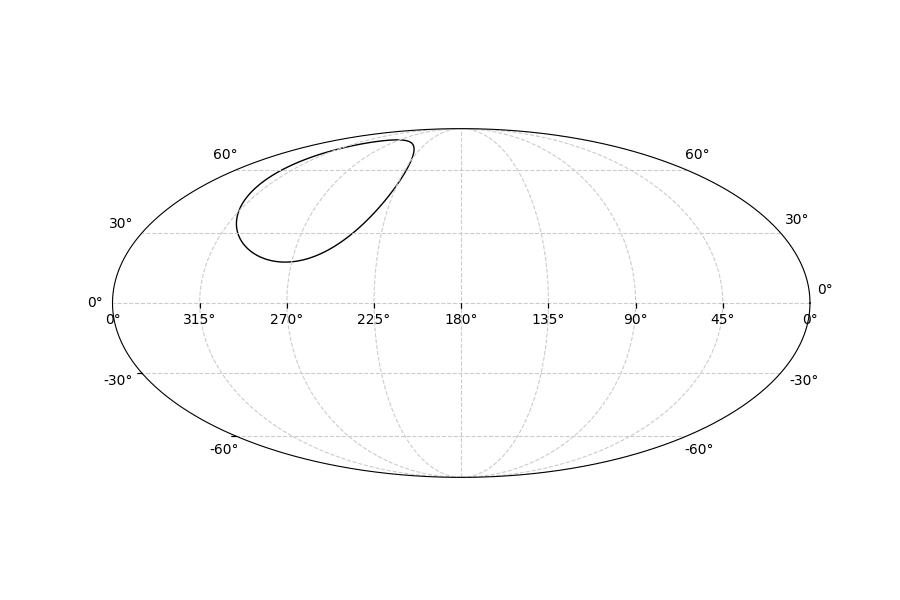

2018-09-12 06:34:13.806000
[0.                0.342910419039635]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


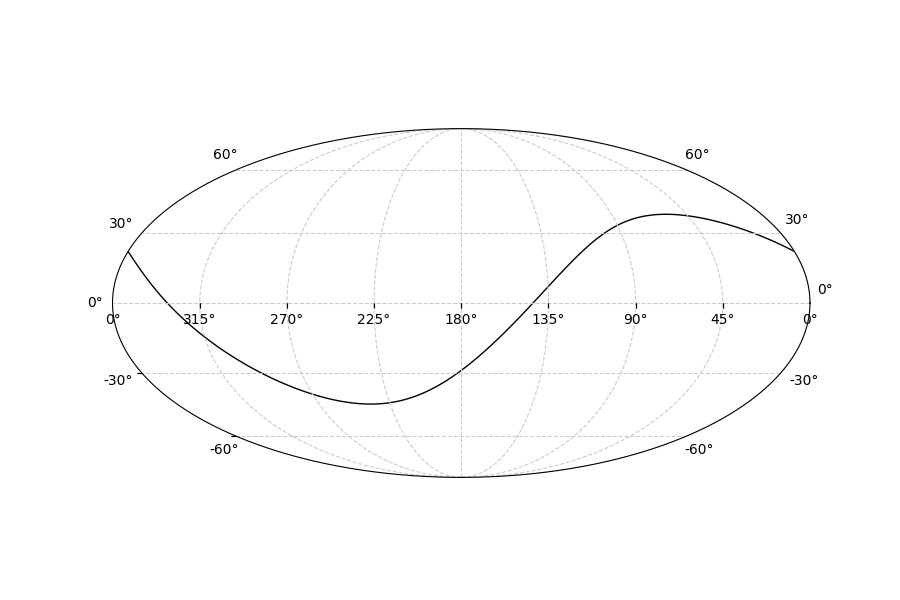

2018-09-13 18:48:07.540000
[0.0217563393812514 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


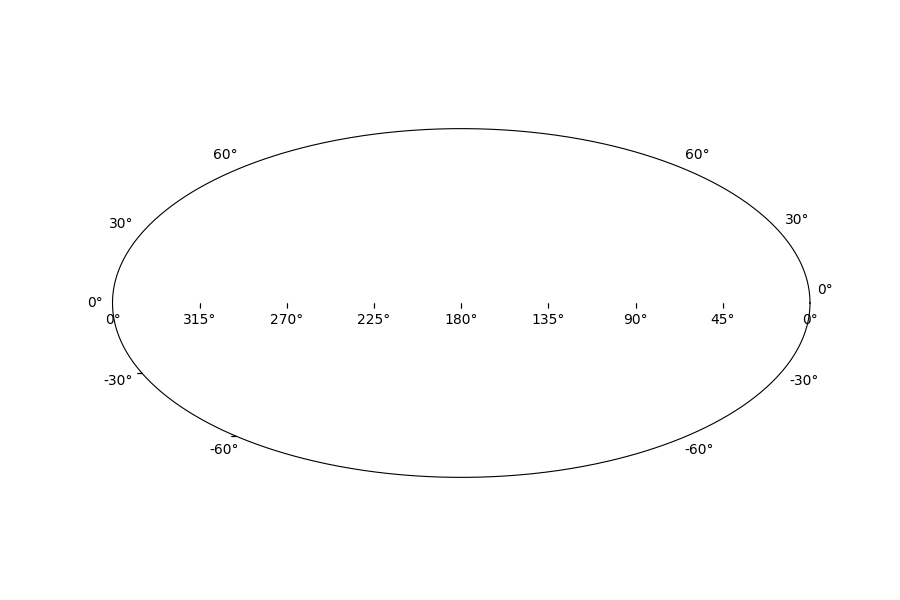

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


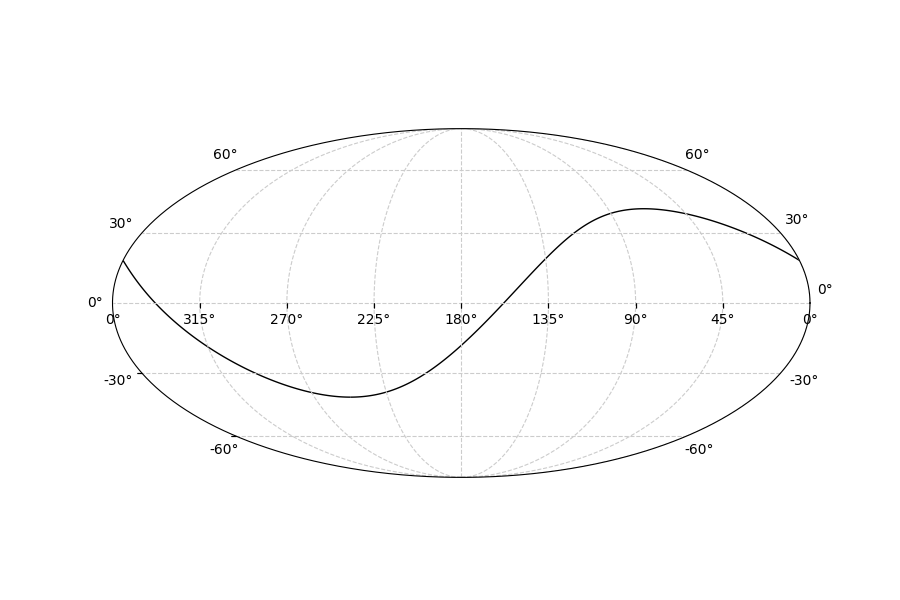

2018-10-02 14:47:47.342000
[0.                 0.0002508231832195]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


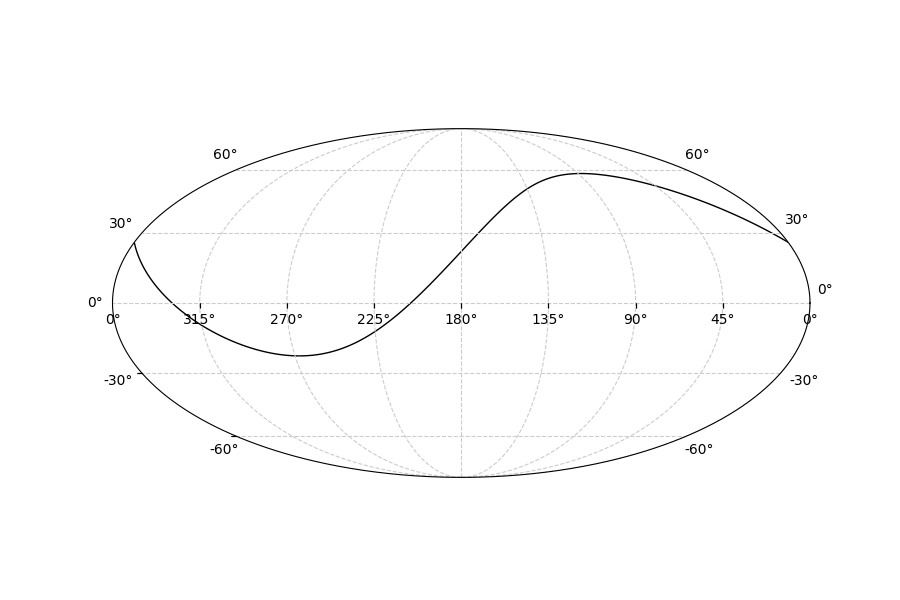

2018-10-16 17:13:25.404000
[0.                 0.1352006143588523]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


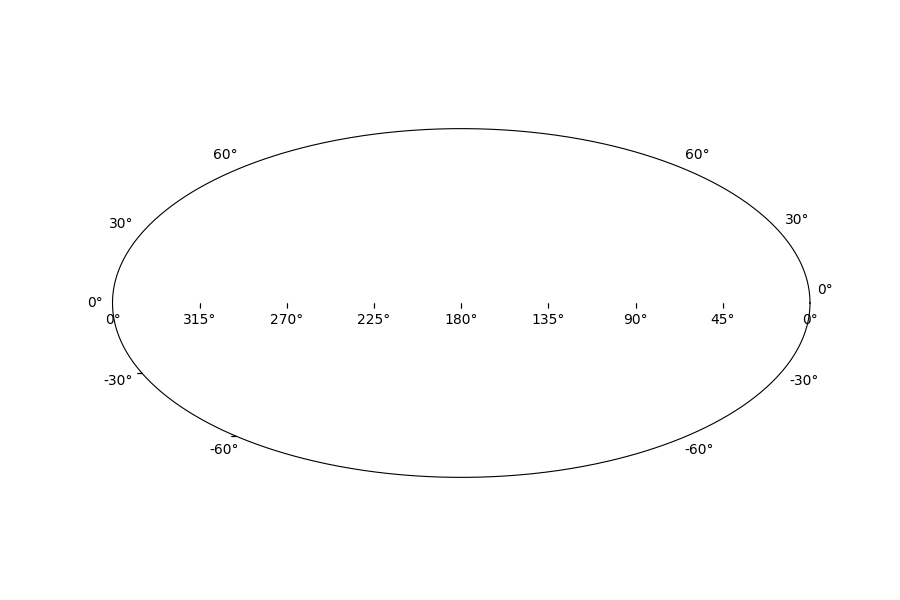

angle theta is nan, given positions or dt is probably wrong


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


<IPython.core.display.Javascript object>


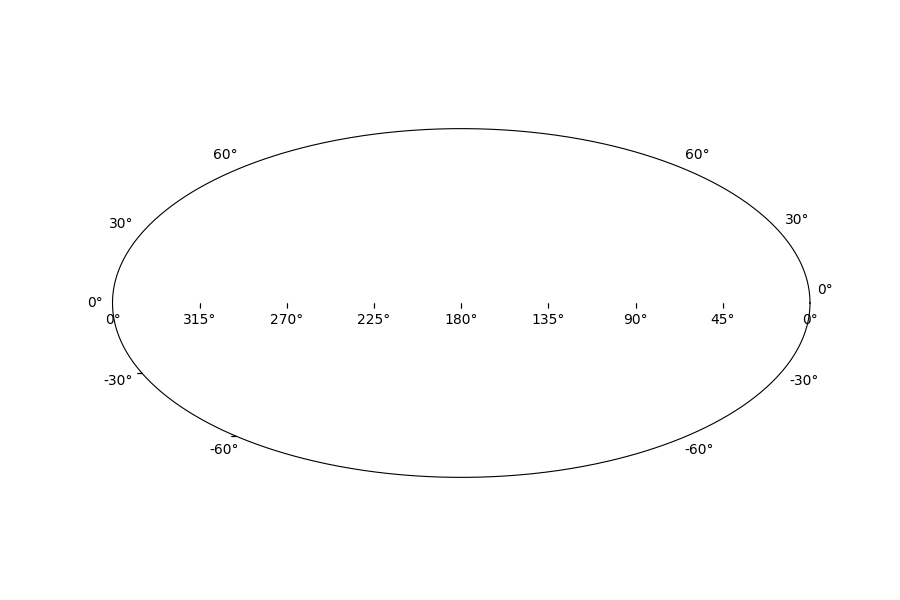

angle theta is nan, given positions or dt is probably wrong


<IPython.core.display.Javascript object>


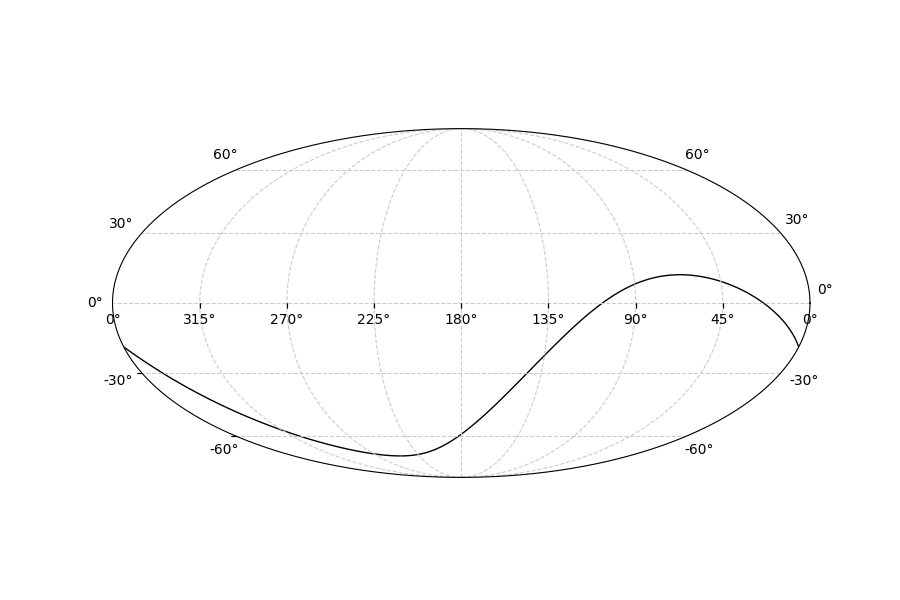

2018-10-26 12:57:00.037000
[0.2493365675459673 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


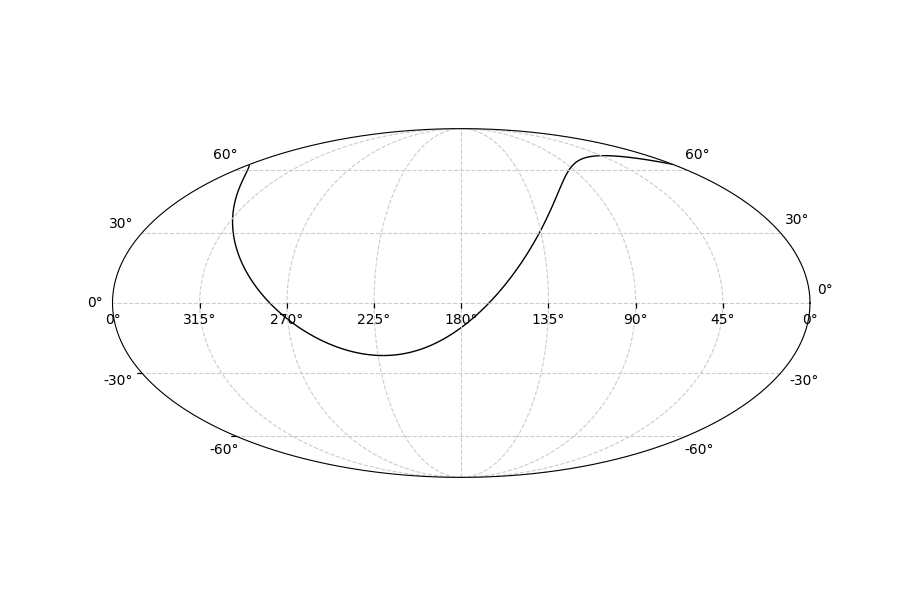

2018-10-28 14:09:42.530000
[0.                 0.1284689457575939]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-11-16 11:36:47.288000
[0.2406772324917387 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-11-17 15:55:18.057000
[0.                0.020100517248386]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-11-20 06:21:19.084000
[0.1541388225960544 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

2018-11-22 09:09:03.060000
[0.0725132383268582 0.                ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


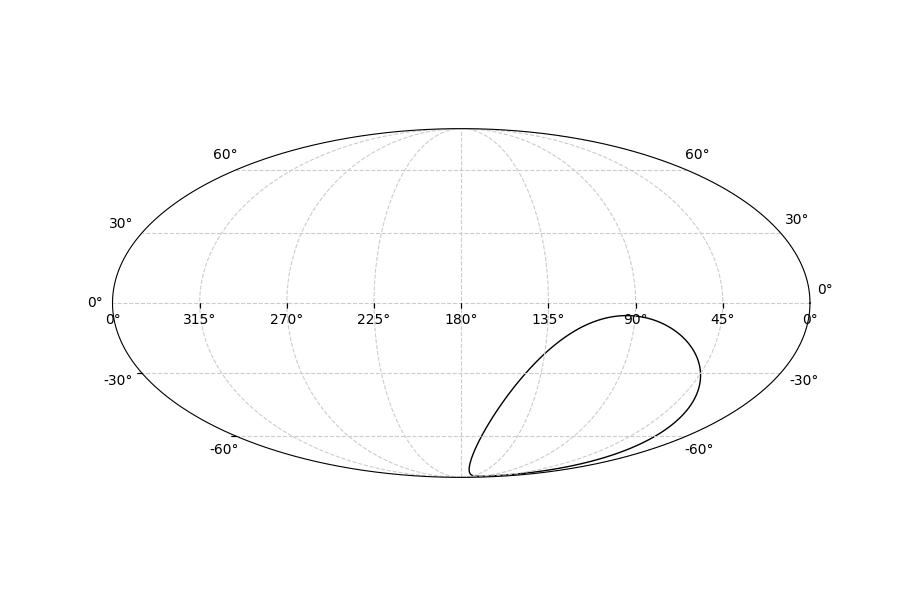

2018-12-22 06:41:34.254000
[0.326959416982212 0.               ]


/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


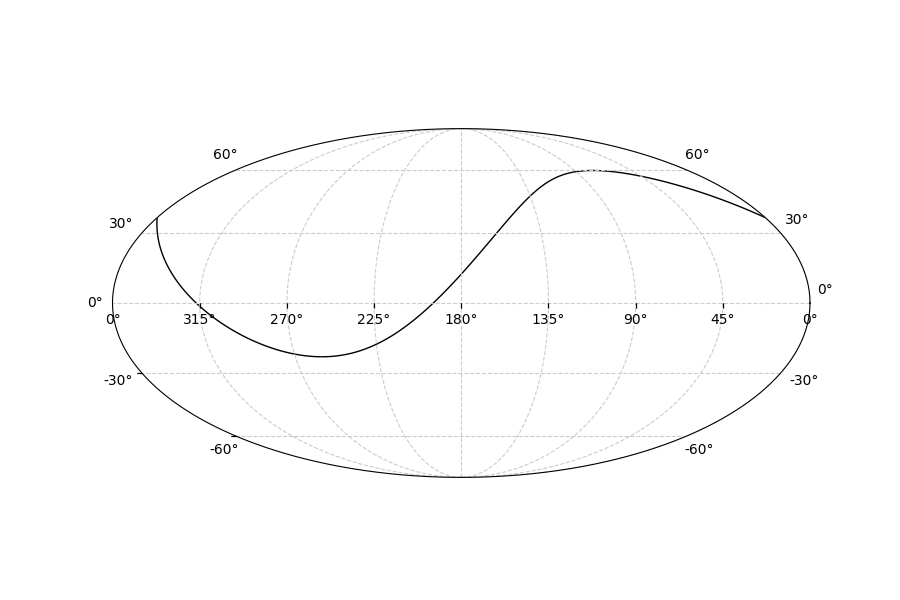

2018-12-27 06:17:00.496000
[0.                 0.1525237564151959]


In [7]:
#plot annuli

from pyipn import copy_template, Universe
from pyipn.detector import Detector
from pyipn.grb import GRB
from pyipn.geometry import Pointing
from pyipn.io.orbits.tle import position_skyfield
import pdb

plt.style.use('default')
mpl.rcParams['figure.figsize'] = [9, 6]

tle_G = 'Glast2018_01_01 00_00_00__2019_12_31 00_00_00_tle.txt'
tle_I = 'Integral2018_01_01 00_00_00__2019_12_31 00_00_00_tle.txt'

for idx, dt in enumerate(np.array([maxim["dt"] for maxim in maxims])):
    trigtime = maxims[idx]['trigtime']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    #pdb.set_trace()
    try:
        fig = uni.plot_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
        
    fig.savefig('annulus.pdf')
    print(time)
    print(uni._T0)
    

In [20]:
#import reference grb data
#find signals in 'close' which are also close to reference signals
#and add to list ref_close

time_delta = 10.
ref_close_d = import_lc.close_to_reference_grb(maxims, time_delta, data_dir="/home/msinghart/data/")
ref_close_lin = import_lc.close_to_reference_grb(maxims_i_lin, time_delta, data_dir="/home/msinghart/data/")
ref_close_spl = import_lc.close_to_reference_grb(maxims_i_spl, time_delta, data_dir="/home/msinghart/data/")
print(len(ref_close_d))

51


In [21]:
#plot annuli and reference points
%matplotlib notebook
import matplotlib.pyplot as plt

from pyipn import copy_template, Universe
from pyipn.detector import Detector
from pyipn.grb import GRB
from pyipn.geometry import Pointing
from pyipn.io.orbits.tle import position_skyfield
import pdb

from astropy.coordinates import SkyCoord
import astropy.units as u

plt.style.use('default')
mpl.rcParams['figure.figsize'] = [9, 6]

tle_G = 'Glast2018_01_01 00_00_00__2019_12_31 00_00_00_tle.txt'
tle_I = 'Integral2018_01_01 00_00_00__2019_12_31 00_00_00_tle.txt'

diff_sep = []

for key, rc in ref_close_spl.items():
    trigtime = rc['trigtime_gbm']
    dt = rc['dt']
    ra = rc['ra']
    dec = rc['dec']
    title = rc['title']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    try:
        #fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
        d, d_vec, theta = uni.calculate_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
    d = SkyCoord(d_vec[0].to_value(u.deg), d_vec[1].to_value(u.deg), unit='deg')
    separation = SkyCoord(ra, dec, unit='deg').separation(d)
    diff_sep.append(abs(separation.to_value(u.deg)-theta.to_value(u.deg)))
    
    #fig.savefig('annulus.pdf')
    print(key)
    print(title)
    #print(uni._T0)
diff_sep_spl = np.array(diff_sep)

diff_sep = []

for key, rc in ref_close_spl.items():
    trigtime = rc['trigtime_gbm']
    dt = rc['dtmax']
    ra = rc['ra']
    dec = rc['dec']
    title = rc['title']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    try:
        #fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
        d, d_vec, theta = uni.calculate_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
    d = SkyCoord(d_vec[0].to_value(u.deg), d_vec[1].to_value(u.deg), unit='deg')
    separation = SkyCoord(ra, dec, unit='deg').separation(d)
    diff_sep.append(abs(separation.to_value(u.deg)-theta.to_value(u.deg)))
    
    #fig.savefig('annulus.pdf')
    print(key)
    print(title)
    #print(uni._T0)
diff_sep_spl_n = np.array(diff_sep)

diff_sep = []

for key, rc in ref_close_lin.items():
    trigtime = rc['trigtime_gbm']
    dt = rc['dtmax']
    ra = rc['ra']
    dec = rc['dec']
    title = rc['title']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    try:
        #fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
        d, d_vec, theta = uni.calculate_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
    d = SkyCoord(d_vec[0].to_value(u.deg), d_vec[1].to_value(u.deg), unit='deg')
    separation = SkyCoord(ra, dec, unit='deg').separation(d)
    diff_sep.append(abs(separation.to_value(u.deg)-theta.to_value(u.deg)))
    
    #fig.savefig('annulus.pdf')
    print(key)
    print(title)
    #print(uni._T0)
diff_sep_lin_n = np.array(diff_sep)

diff_sep = []

for key, rc in ref_close_lin.items():
    trigtime = rc['trigtime_gbm']
    dt = rc['dt']
    ra = rc['ra']
    dec = rc['dec']
    title = rc['title']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    try:
        #fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
        d, d_vec, theta = uni.calculate_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
    d = SkyCoord(d_vec[0].to_value(u.deg), d_vec[1].to_value(u.deg), unit='deg')
    separation = SkyCoord(ra, dec, unit='deg').separation(d)
    diff_sep.append(abs(separation.to_value(u.deg)-theta.to_value(u.deg)))
    
    #fig.savefig('annulus.pdf')
    print(key)
    print(title)
    #print(uni._T0)
diff_sep_lin = np.array(diff_sep)

diff_sep = []

for key, rc in ref_close_d.items():
    trigtime = rc['trigtime_gbm']
    dt = rc['dtmax']
    ra = rc['ra']
    dec = rc['dec']
    title = rc['title']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    try:
        #fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
        d, d_vec, theta = uni.calculate_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
    d = SkyCoord(d_vec[0].to_value(u.deg), d_vec[1].to_value(u.deg), unit='deg')
    separation = SkyCoord(ra, dec, unit='deg').separation(d)
    diff_sep.append(abs(separation.to_value(u.deg)-theta.to_value(u.deg)))
    
    #fig.savefig('annulus.pdf')
    print(key)
    print(title)
    #print(uni._T0)
diff_sep_d_n = np.array(diff_sep)

diff_sep = []

for key, rc in ref_close_d.items():
    trigtime = rc['trigtime_gbm']
    dt = rc['dt']
    ra = rc['ra']
    dec = rc['dec']
    title = rc['title']
    
    time = trigtime.datetime
    p = Pointing(0.6*360, (0.4-0.5)*180)
    integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                              p,
                              'INTEGRAL')
    glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                            p,
                           'GLAST')
    
    uni = Universe(None)
    uni.register_detector(integral)
    uni.register_detector(glast)
    uni._T0 = np.zeros(2)
    if dt > 0.:
        uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
    else:
        uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt
       
    try:
        #fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
        d, d_vec, theta = uni.calculate_annulus(glast.name, integral.name)
    except ValueError as err:
        print(err)
        continue
    d = SkyCoord(d_vec[0].to_value(u.deg), d_vec[1].to_value(u.deg), unit='deg')
    separation = SkyCoord(ra, dec, unit='deg').separation(d)
    diff_sep.append(abs(separation.to_value(u.deg)-theta.to_value(u.deg)))
    
    #fig.savefig('annulus.pdf')
    print(key)
    print(title)
    #print(uni._T0)
diff_sep_d = np.array(diff_sep)

2018-01-13_02:47:06
['GCN/FERMI', 'NOTICE']
2018-01-13_02:47:06_1
['GCN/SWIFT', 'NOTICE']
2018-04-02_09:44:59
['GCN/SWIFT', 'NOTICE']
2018-04-02_09:44:59_1
['GCN/FERMI', 'NOTICE']
2018-04-18_06:44:06
['GCN/SWIFT', 'NOTICE']
2018-04-18_06:44:06_1
['GCN/FERMI', 'NOTICE']
2018-04-18_06:44:06_2
['GCN/SWIFT', 'NOTICE']
2018-06-18_00:43:13
['GCN/SWIFT', 'NOTICE']
2018-06-18_00:43:13_1
['GCN/SWIFT', 'NOTICE']
2018-06-26_09:23:50
['GCN/FERMI', 'NOTICE']
2018-07-03_21:01:40
['GCN/FERMI', 'NOTICE']
2018-07-03_22:46:51
['GCN/FERMI', 'NOTICE']
2018-07-03_22:46:51_1
['GCN/FERMI', 'NOTICE']
2018-07-15_18:07:05
['GCN/SWIFT', 'NOTICE']
2018-07-15_18:07:05_1
['GCN/FERMI', 'NOTICE']
2018-07-18_01:57:44
['GCN/FERMI', 'NOTICE']
angle theta is nan, given positions or dt is probably wrong
2018-07-20_14:21:39
['GCN/FERMI', 'NOTICE']
2018-07-20_14:21:39_1
['GCN/FERMI', 'NOTICE']
2018-07-20_14:21:39_2
['GCN/SWIFT', 'NOTICE']
2018-07-28_17:29:02
['GCN/SWIFT', 'NOTICE']
2018-07-28_17:29:02_1
['GCN/FERMI', 'NOTIC

/home/msinghart/.vevn/pyipn/lib/python3.5/site-packages/pyipn-0.1.0-py3.5.egg/pyipn/universe.py:252: RuntimeWarning: invalid value encountered in arccos
  np.around((constants.c * dt / distance).decompose().value, 15)


2018-11-20_06:21:19_1
['GCN/FERMI', 'NOTICE']
2018-12-22_06:41:34
['GCN/FERMI', 'NOTICE']
2018-12-27_06:17:00
['GCN/FERMI', 'NOTICE']
2019-01-14_20:57:02
['GCN/FERMI', 'NOTICE']
2019-01-14_20:57:02_1
['GCN/SWIFT', 'NOTICE']
2019-02-02_01:39:26
['GCN/FERMI', 'NOTICE']
2019-02-02_01:39:26_1
['GCN/SWIFT', 'NOTICE']
2019-03-24_22:44:02
['GCN/SWIFT', 'NOTICE']
2019-03-24_22:44:02_1
['GCN/FERMI', 'NOTICE']
2019-04-15_04:09:49
['GCN/FERMI', 'NOTICE']
2019-05-30_10:19:08
['GCN/FERMI', 'NOTICE']
2019-05-30_10:19:08_1
['GCN/FERMI', 'NOTICE']
2019-06-11_22:47:49
['GCN/FERMI', 'NOTICE']
angle theta is nan, given positions or dt is probably wrong
2019-07-27_20:17:56
['GCN/FERMI', 'NOTICE']
2019-08-10_16:12:01
['GCN/FERMI', 'NOTICE']
2019-08-28_12:59:59
['GCN/SWIFT', 'NOTICE']
2019-08-28_12:59:59_1
['GCN/FERMI', 'NOTICE']
2019-10-31_18:43:16
['GCN/FERMI', 'NOTICE']
2019-10-31_21:23:31
['GCN/SWIFT', 'NOTICE']
2019-10-31_21:23:31_1
['GCN/SWIFT', 'NOTICE']
angle theta is nan, given positions or dt is p

2019-08-28_12:59:59_1
['GCN/FERMI', 'NOTICE']
2019-10-31_18:43:16
['GCN/FERMI', 'NOTICE']
2019-10-31_21:23:31
['GCN/SWIFT', 'NOTICE']
2019-10-31_21:23:31_1
['GCN/SWIFT', 'NOTICE']
angle theta is nan, given positions or dt is probably wrong
2019-12-27_01:39:24
['GCN/FERMI', 'NOTICE']
2018-01-13_02:47:06
['GCN/FERMI', 'NOTICE']
2018-01-13_02:47:06_1
['GCN/SWIFT', 'NOTICE']
2018-04-02_09:44:59
['GCN/SWIFT', 'NOTICE']
2018-04-02_09:44:59_1
['GCN/FERMI', 'NOTICE']
2018-04-18_06:44:06
['GCN/SWIFT', 'NOTICE']
2018-04-18_06:44:06_1
['GCN/FERMI', 'NOTICE']
2018-04-18_06:44:06_2
['GCN/SWIFT', 'NOTICE']
2018-06-18_00:43:13
['GCN/SWIFT', 'NOTICE']
2018-06-18_00:43:13_1
['GCN/SWIFT', 'NOTICE']
angle theta is nan, given positions or dt is probably wrong
2018-07-03_21:01:40
['GCN/FERMI', 'NOTICE']
2018-07-03_22:46:51
['GCN/FERMI', 'NOTICE']
2018-07-03_22:46:51_1
['GCN/FERMI', 'NOTICE']
2018-07-15_18:07:05
['GCN/SWIFT', 'NOTICE']
2018-07-15_18:07:05_1
['GCN/FERMI', 'NOTICE']
2018-07-18_01:57:44
['GCN/

2018-12-27_06:17:00


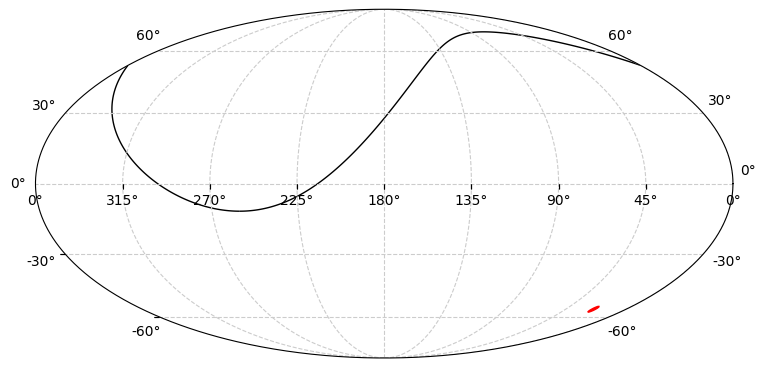

In [20]:
#plot annuli and reference points same but without for loop
%matplotlib inline
import matplotlib.pyplot as plt

from pyipn import copy_template, Universe
from pyipn.detector import Detector
from pyipn.grb import GRB
from pyipn.geometry import Pointing
from pyipn.io.orbits.tle import position_skyfield
import pdb

plt.style.use('default')
mpl.rcParams['figure.figsize'] = [9, 6]

tle_G = 'Glast2018_01_01 00_00_00__2019_12_31 00_00_00_tle.txt'
tle_I = 'Integral2018_01_01 00_00_00__2019_12_31 00_00_00_tle.txt'

key = '2018-12-27_06:17:00'
rc = ref_close[key]
trigtime = rc['trigtime_gbm']
dt = rc['dt']
ra = rc['ra']
dec = rc['dec']

time = trigtime.datetime
p = Pointing(0.6*360, (0.4-0.5)*180)
integral = Detector.from_GCRS(position_skyfield(time, tle_I),
                          p,
                          'INTEGRAL')
glast = Detector.from_GCRS(position_skyfield(time, tle_G),
                        p,
                       'GLAST')

uni = Universe(None)
uni.register_detector(integral)
uni.register_detector(glast)
uni._T0 = np.zeros(2)
if dt > 0.:
    uni._T0[list(uni._detectors.keys()).index(glast.name)] = dt
else:
    uni._T0[list(uni._detectors.keys()).index(integral.name)] = -dt

#pdb.set_trace()
try:
    fig = uni.plot_annulus(glast.name, integral.name, point=(ra,dec))
except ValueError as err:
    print(err)

    
fig.savefig('very_bad_annulus.pdf')
print(key)
#print(uni._T0)

<IPython.core.display.Javascript object>


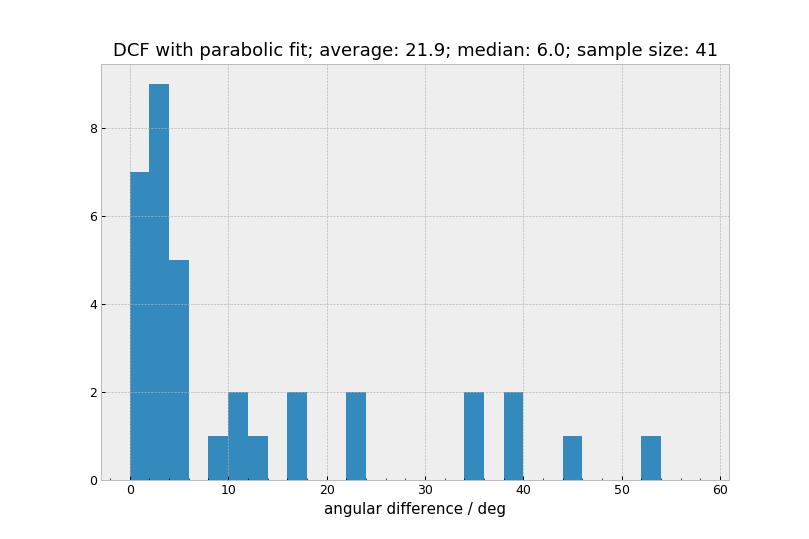

<IPython.core.display.Javascript object>


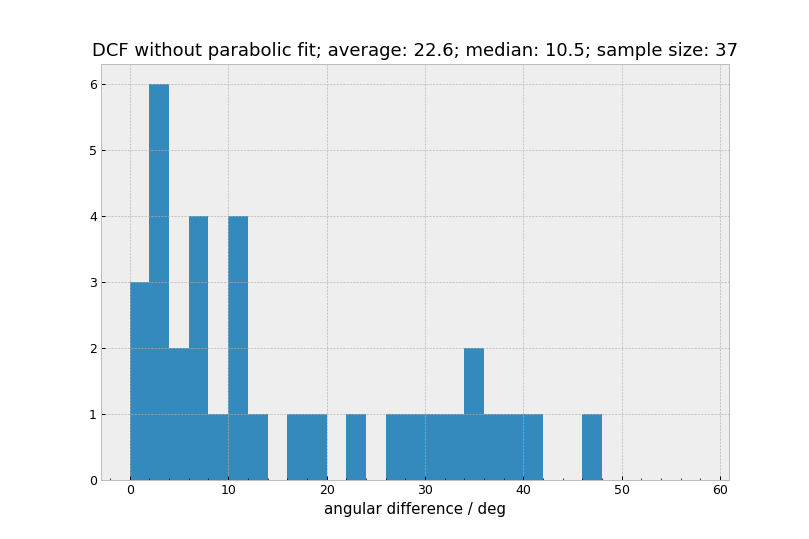

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


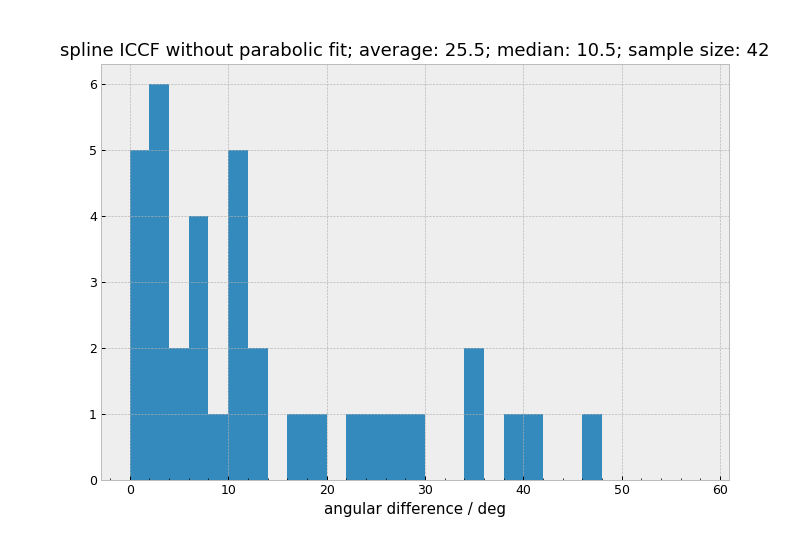

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


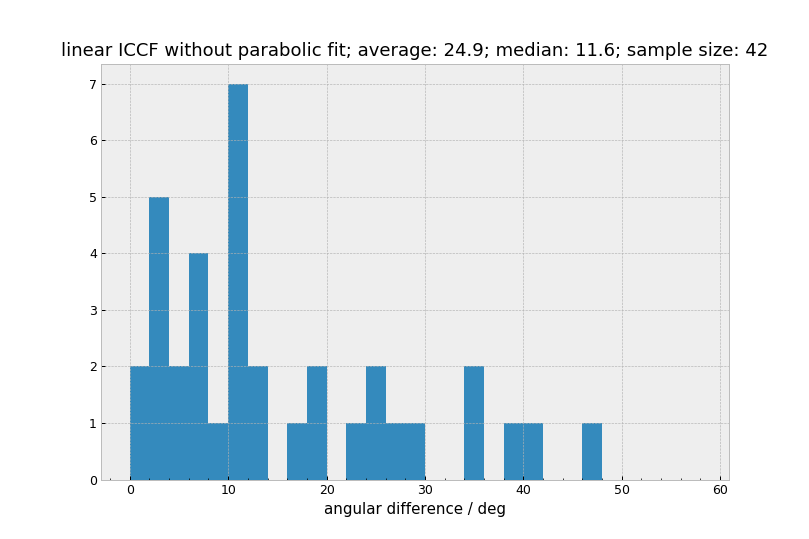

In [22]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

plt.style.use('bmh')
%matplotlib notebook
bins = np.arange(0., 60., 2)

avg_lin = np.around(np.mean(diff_sep_lin), decimals=1)
avg_lin_n = np.around(np.mean(diff_sep_lin_n), decimals=1)
avg_spl = np.around(np.mean(diff_sep_spl), decimals=1)
avg_spl_n = np.around(np.mean(diff_sep_spl_n), decimals=1)
avg_d = np.around(np.mean(diff_sep_d), decimals=1)
avg_d_n = np.around(np.mean(diff_sep_d_n), decimals=1)

med_lin = np.around(np.median(diff_sep_lin), decimals=1)
med_lin_n = np.around(np.median(diff_sep_lin_n), decimals=1)
med_spl = np.around(np.median(diff_sep_spl), decimals=1)
med_spl_n = np.around(np.median(diff_sep_spl_n), decimals=1)
med_d = np.around(np.median(diff_sep_d), decimals=1)
med_d_n = np.around(np.median(diff_sep_d_n), decimals=1)

fig, axs = plt.subplots()
axs.hist(diff_sep_d, bins=bins)
axs.set_xlabel('angular difference / deg')
axs.set_title('DCF with parabolic fit; average: {}; median: {}; sample size: {}'.format(avg_d, med_d, diff_sep_d.shape[0]))
axs.xaxis.set_major_locator(MultipleLocator(10))
axs.xaxis.set_minor_locator(AutoMinorLocator(5))
fig.savefig('anglefromref_dcf_trigdat{}.pdf'.format(stepsize))

fig0, axs0 = plt.subplots()
axs0.hist(diff_sep_d_n, bins=bins)
axs0.set_xlabel('angular difference / deg')
axs0.set_title('DCF without parabolic fit; average: {}; median: {}; sample size: {}'.format(avg_d_n, med_d_n, diff_sep_d_n.shape[0]))
axs0.xaxis.set_major_locator(MultipleLocator(10))
axs0.xaxis.set_minor_locator(AutoMinorLocator(5))
fig0.savefig('anglefromref_dcf_no_fit_trigdat{}.pdf'.format(stepsize))

fig1, axs1 = plt.subplots()
axs1.hist(diff_sep_spl, bins=bins)
axs1.set_xlabel('angular difference / deg')
axs1.set_title('spline ICCF with parabolic fit; average: {}; median: {}; sample size: {}'.format(avg_spl, med_spl, diff_sep_spl.shape[0]))
axs1.xaxis.set_major_locator(MultipleLocator(10))
axs1.xaxis.set_minor_locator(AutoMinorLocator(5))
fig1.savefig('anglefromref_spl_trigdat{}.pdf'.format(stepsize))

fig2, axs2 = plt.subplots()
axs2.hist(diff_sep_spl_n, bins=bins)
axs2.set_xlabel('angular difference / deg')
axs2.set_title('spline ICCF without parabolic fit; average: {}; median: {}; sample size: {}'.format(avg_spl_n, med_spl_n, diff_sep_spl_n.shape[0]))
axs2.xaxis.set_major_locator(MultipleLocator(10))
axs2.xaxis.set_minor_locator(AutoMinorLocator(5))
fig2.savefig('anglefromref_spl_no_fit_trigdat{}.pdf'.format(stepsize))

fig3, axs3 = plt.subplots()
axs3.hist(diff_sep_lin, bins=bins)
axs3.set_xlabel('angular difference / deg')
axs3.set_title('linear ICCF with parabolic fit; average: {}; median: {}; sample size: {}'.format(avg_lin, med_lin, diff_sep_lin.shape[0]))
axs3.xaxis.set_major_locator(MultipleLocator(10))
axs3.xaxis.set_minor_locator(AutoMinorLocator(5))
fig3.savefig('anglefromref_lin_trigdat{}.pdf'.format(stepsize))

fig4, axs4 = plt.subplots()
axs4.hist(diff_sep_lin_n, bins=bins)
axs4.set_xlabel('angular difference / deg')
axs4.set_title('linear ICCF without parabolic fit; average: {}; median: {}; sample size: {}'.format(avg_lin_n, med_lin_n, diff_sep_lin_n.shape[0]))
axs4.xaxis.set_major_locator(MultipleLocator(10))
axs4.xaxis.set_minor_locator(AutoMinorLocator(5))
fig4.savefig('anglefromref_lin_no_fit_trigdat{}.pdf'.format(stepsize))

